This Notebook is comapnion example code found in Chapter 5 of the book [Deep Learning Models: A Practical Approach for Hands-On Professionals]. It is an example of the application of deep learning algorithms to remote sensing. It has be successfully executed in Google Colab. Access to Googl. e Drive will be requeired for this example to work with the necessary path modifications. We make a comparison of the performance of various classes of Keras models using the publicly available [EuroSat dataset](https://github.com/phelber/EuroSAT ) as input. Specifically, we will evaluate ResNet, VGG, NasNet and EfficientNet V1 models to see how they compare under similar conditions except where model specific treatment is necessary.
The reference notebook on which we build can be found [here](https://www.kaggle.com/silentj23/eurosat-image-classification#II.-Preprocessing)

In [ ]:
# Import packages needed for data loading and inspection
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

Mount the Google Drive to Google Colab.

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


# I.Exploration of the Dataset

In this section, we will explore the EuroSAT dataset. The dataset is composed of images taken from the Sentinel-2 satellite. This dataset consists of 10-class labeled images. 

In [ ]:
#DATASET = "../input/EUROSAT"
DATASET = "/content/drive/My Drive/Colab Notebooks/EuroSAT/2750"
LABELS = os.listdir(DATASET)
print(LABELS)

['AnnualCrop', 'Pasture', 'PermanentCrop', 'Residential', 'Industrial', 'River', 'SeaLake', 'HerbaceousVegetation', 'Highway', 'Forest']


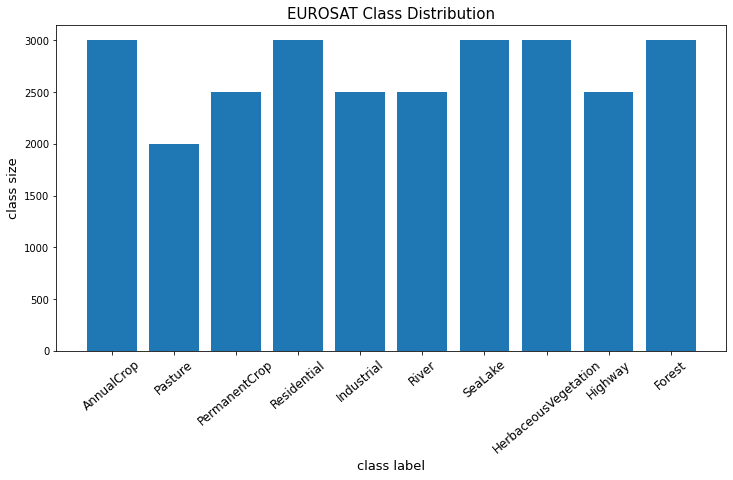

In [ ]:
# Plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

The dataset is split into 10 classes of land cover. Each class varies in size, so I'll have to stratify later on when splitting the data into training, testing and validation sets. 

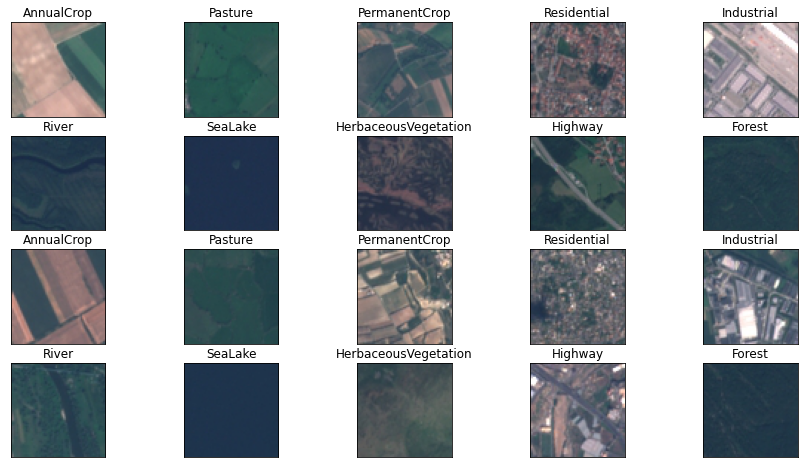

In [ ]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

The sample data shows the variability in contents of the classes from AnnualCrop to Forest. Some similarities can be observed, for example, between Industrial and Highway classes, also between Pasture, River and Forest.This similarity is generally the case for most datasets. The challenge for the deep learning algorithms is to be able to distinguish these classes by minimizing false positives and false negatives among other metrics that can be used. 

Although NIR band data is also available, our evaluation will solely use RGB bands as it has been already demonstrated that RGB can give high accuracy.



# II. Preprocessing, Path Setting and Function Definitions

Next the data is split into training and test sets using stratified shuffle-split from Scikit-learn. We also make use Keras ImageDataGenerator for data augmentation. 

In [ ]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/training'
TEST_DIR = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# Create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# Create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [ ]:
# EXECUTE ONCE!!!!! Map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    s_in ='/content/drive/My Drive/Colab Notebooks/EuroSAT/2750'
    s_train ='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/training'
    s_test = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/testing'
    new_train_paths = [re.sub(s_in, s_train, i) for i in train_paths]
    new_test_paths = [re.sub(s_in, s_test, i) for i in test_paths]
    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # Move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
              shutil.copy(i[0], i[1])   
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

moving training files..


100%|██████████| 21600/21600 [1:35:13<00:00,  3.78it/s]


moving testing files..


100%|██████████| 5400/5400 [24:17<00:00,  3.70it/s]


In [ ]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
# To speed up the training, we keep validation set as optional.
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# Test generator for evaluation purposes with no augmentations. Only rescaling is applied to the images.
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [ ]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [ ]:
np.save('class_indices', train_generator.class_indices)

We then define the utility functions for model selection and compilation,  and for visualization of performance metrics.

In [ ]:
# Current: Note that for different CNN models we are using different setup of dense layers
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    
    if (cnn_base == 'ResNet50') or (cnn_base == 'ResNet50V2') or (cnn_base == 'ResNet152V2') or (cnn_base == 'ResNet101') or (cnn_base == 'ResNet152'):
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet50V2':
            conv_base = ResNet50V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet101':
            conv_base = ResNet101(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet152':
            conv_base = ResNet152(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        else:
            conv_base = ResNet152V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = BatchNormalization()(top_model) #added
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = BatchNormalization()(top_model) #added
        top_model = Dropout(0.2)(top_model)
    
    elif (cnn_base == 'VGG16') or (cnn_base == 'VGG19'):
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = VGG19(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        #top_model = Dense(512, kernel_regularizer=regularizers.l2(1e-4), activation='relu')(top_model) #test3 reg: Dense(512, kernel_regularizer=regularizers.l2(1e-4))
        #top_model = Dense(1024, activity_regularizer=regularizers.l2(1e-4), activation='relu')(top_model) #test6 reg: Dense(512, activity_regularizer=regularizers.l2(1e-4))
        top_model = Dense(1024, activity_regularizer=regularizers.l2(1e-4), activation='relu')(top_model)
        top_model = BatchNormalization()(top_model) #added
        top_model = Dropout(0.2)(top_model)
        #top_model = Dense(512, kernel_regularizer=regularizers.l2(1e-4), activation='relu')(top_model) # test3 reg - default units =2048, cap_red =1024,512
        #top_model = Dense(1024, activity_regularizer=regularizers.l2(1e-4), activation='relu')(top_model) #test6 reg: Dense(512, activity_regularizer=regularizers.l2(1e-4)
        top_model = Dense(1024, activity_regularizer=regularizers.l2(1e-4), activation='relu')(top_model)
        top_model = BatchNormalization()(top_model) #added
        top_model = Dropout(0.2)(top_model) 
        #top_model = Dense(1024, activity_regularizer=regularizers.l2(1e-4), activation='relu')(top_model) # add layers
        #top_model = BatchNormalization()(top_model) #added
        #top_model = Dropout(0.2)(top_model)
    elif (cnn_base == 'Xception') or (cnn_base == 'InceptionV3'):
        if cnn_base == 'Xception':
            conv_base = Xception(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = InceptionV3(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = GlobalAveragePooling2D()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model) 
    elif (cnn_base == 'NASNetLarge') or (cnn_base == 'NASNetMobile'):
        if cnn_base == 'NASNetLarge':
            conv_base = NASNetLarge(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)   
        else:
            conv_base = NASNetMobile(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = GlobalAveragePooling2D()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = BatchNormalization()(top_model) #added
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = BatchNormalization()(top_model) #added
        top_model = Dropout(0.2)(top_model) 
    elif (cnn_base == 'EfficientNetB0') or (cnn_base == 'EfficientNetB1') or (cnn_base == 'EfficientNetB2') or (cnn_base == 'EfficientNetB3') or (cnn_base == 'EfficientNetB4') or (cnn_base == 'EfficientNetB5') or (cnn_base == 'EfficientNetB6') or (cnn_base == 'EfficientNetB7'):
        if cnn_base == 'EfficientNetB0':
          conv_base = EfficientNetB0(include_top=False,
                                     weights="imagenet",
                                     input_shape=input_shape)
        elif cnn_base == 'EfficientNetB1':
          conv_base = EfficientNetB1(include_top=False,
                                     weights="imagenet",
                                     input_shape=input_shape)
        elif cnn_base == 'EfficientNetB2':
          conv_base = EfficientNetB2(include_top=False,
                                     weights="imagenet",
                                     input_shape=input_shape)
        elif cnn_base == 'EfficientNetB3':
          conv_base = EfficientNetB3(include_top=False,
                                     weights="imagenet",
                                     input_shape=input_shape)
        elif cnn_base == 'EfficientNetB4':
          conv_base = EfficientNetB4(include_top=False,
                                     weights="imagenet",
                                     input_shape=input_shape)
        elif cnn_base == 'EfficientNetB5':
          conv_base = EfficientNetB5(include_top=False,
                                     weights="imagenet",
                                     input_shape=input_shape)
        elif cnn_base == 'EfficientNetB6':
          conv_base = EfficientNetB6(include_top=False,
                                     weights="imagenet",
                                     input_shape=input_shape)
        else:
          conv_base = EfficientNetB7(include_top=False,
                                     weights="imagenet",
                                     input_shape=input_shape)
        top_model = conv_base.output
        top_model = GlobalAveragePooling2D()(top_model)
        #top_model = BatchNormalization()(top_model) #added
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = BatchNormalization()(top_model) #added
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = BatchNormalization()(top_model) #added
        top_model = Dropout(0.2)(top_model) 

    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model


In [ ]:
def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    

# III. Load Necessary Packages

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam 
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet import ResNet50, ResNet101, ResNet152
from tensorflow.keras.applications import ResNet50V2, ResNet50V2, ResNet152V2
#from keras.applications import InceptionV3, Xception
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score, roc_curve, roc_auc_score, auc
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB4, EfficientNetB5
from tensorflow.keras.applications import EfficientNetB6, EfficientNetB7
from tensorflow.keras.regularizers import l2,l1, l1_l2
from tensorflow.python.keras import regularizers

Configure GPUs for processing if available. It is recommended to use the first available GPU for Tensorflow processing in the [guide](https://www.tensorflow.org/guide/gpu#using_multiple_gpus).

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5'

We then define the generic functions for model selection and compilation,  and for visualization of performance metrics.

# IV. Evaluation of Models

Models Evaluated:
## ResNet Models 
ResNet50

ResNet101 

ResNet152

## VGG Models
VGG16

VGG19 

## NasNet Models
NasNetLarge 

NasNetMobile

## EfficientNet Models
EfficientNet B0 

EfficientNet B1

EfficientNet B2 

EfficientNet B3 

EfficientNet B4 

EfficientNet B5 

EfficientNet B6 

EfficientNet B7 

Evaluation Method  
•	Training/Validation accuracy and loss

•	Precision, Recall, F2 Score (PRF) 

•	Confusion Matrix


In [ ]:
# Model parameters
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# Model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

# ResNet Models

# RESNET50

In [ ]:
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
resnet50_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
# First Pretraining the dense layer
resnet50_history = resnet50_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
147/147 [==============================] - 100s 644ms/step - loss: 3.1137 - categorical_accuracy: 0.1937 - val_loss: 1.8348 - val_categorical_accuracy: 0.2826

Epoch 00001: val_categorical_accuracy improved from -inf to 0.28257, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
147/147 [==============================] - 92s 630ms/step - loss: 1.8928 - categorical_accuracy: 0.2540 - val_loss: 1.7863 - val_categorical_accuracy: 0.3129

Epoch 00002: val_categorical_accuracy improved from 0.28257 to 0.31291, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
147/147 [==============================] - 93s 633ms/step - loss: 1.8250 - categorical_accuracy: 0.2774 - val_loss: 1.8144 - val_categorical_accuracy: 0.3131

Epoch 00003: val_categorical_accuracy improved from 0.31291 to 0.31311, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/50
147/147 [==============================] - 89s 607ms/step - loss: 1.7964 - categorical_accuracy: 0.2871 - val_loss: 1.6877 - val_categorical_accuracy: 0.3606

Epoch 00004: val_categorical_accuracy improved from 0.31311 to 0.36059, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weig

In [ ]:
# Re-train whole network end2end 
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

resnet50_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50_history = resnet50_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
147/147 [==============================] - 105s 662ms/step - loss: 3.0641 - categorical_accuracy: 0.7131 - val_loss: 5.6535 - val_categorical_accuracy: 0.1002

Epoch 00001: val_categorical_accuracy did not improve from 0.49513
Epoch 2/100
147/147 [==============================] - 95s 646ms/step - loss: 0.4371 - categorical_accuracy: 0.8741 - val_loss: 11.2447 - val_categorical_accuracy: 0.1108

Epoch 00002: val_categorical_accuracy did not improve from 0.49513
Epoch 3/100
147/147 [==============================] - 95s 644ms/step - loss: 0.3063 - categorical_accuracy: 0.9009 - val_loss: 107.7878 - val_categorical_accuracy: 0.1002

Epoch 00003: val_categorical_accuracy did not improve from 0.49513
Epoch 4/100
147/147 [==============================] - 94s 636ms/step - loss: 0.2566 - categorical_accuracy: 0.9195 - val_loss: 12.6279 - val_categorical_accuracy: 0.1020

Epoch 00004: val_categorical_accuracy did not improve from 0.49513
Epoch 5/100
147/147 [======================

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/100
147/147 [==============================] - 95s 643ms/step - loss: 0.1592 - categorical_accuracy: 0.9476 - val_loss: 0.3254 - val_categorical_accuracy: 0.9014

Epoch 00008: val_categorical_accuracy improved from 0.63484 to 0.90138, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 9/100
147/147 [==============================] - 94s 637ms/step - loss: 0.1460 - categorical_accuracy: 0.9519 - val_loss: 0.1581 - val_categorical_accuracy: 0.9519

Epoch 00009: val_categorical_accuracy improved from 0.90138 to 0.95191, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 10/100
147/147 [==============================] - 94s 638ms/step - loss: 0.1365 - categorical_accuracy: 0.9533 - val_loss: 0.1431 - val_categorical_accuracy: 0.9563

Epoch 00010: val_categorical_accuracy improved from 0.95191 to 0.95627, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.

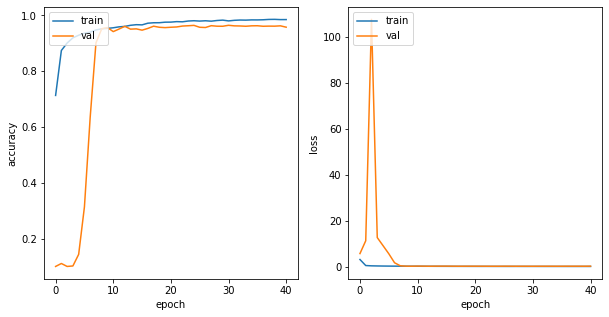

In [ ]:
plot_history(resnet50_history)
resnet50_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

In [ ]:
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet50_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 9882 images belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Global F2 Score: 0.9640760979558793


Precision    Recall   F-Score  Support
AnnualCrop             0.972362  0.958712  0.965489   1211.0
Forest                 0.950988  0.999169  0.974484   1204.0
HerbaceousVegetation   0.974227  0.948161  0.961017   1196.0
Highway                0.981180  0.944811  0.962652   1214.0
Industrial             0.977089  0.966667  0.971850    750.0
Pasture                0.962393  0.938333  0.950211    600.0
PermanentCrop          0.922018  0.954869  0.938156    842.0
Residential            0.946616  1.000000  0.972576    993.0
River                  0.949153  0.979021  0.963855    858.0
SeaLake                1.000000  0.943787  0.971081   1014.0

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 97.24    0.00  ...   0.79      0.0
Forest                      0.00   95.10  ...   0.00      0.0
HerbaceousVegetation        0.25    0.95  ...   0.00      0.0
Highway                     0.59    0.08  ...   3.84      0.0
Industrial                  0.00    0.00  ...   0.00      0.0
Pasture                     0.25    1.58  ...   0.00      0.0
PermanentCrop               0.17    0.08  ...   0.00      0.0
Residential                 0.00    0.00  ...   0.00      0.0
River                       0.17    0.00  ...  94.92      0.0
SeaLake                     1.34    2.21  ...   0.45    100.0

[10 rows x 10 columns]

In [ ]:
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                  1161       0  ...      7        0
Forest                         0    1203  ...      0        0
HerbaceousVegetation           3      12  ...      0        0
Highway                        7       1  ...     34        0
Industrial                     0       0  ...      0        0
Pasture                        3      20  ...      0        0
PermanentCrop                  2       1  ...      0        0
Residential                    0       0  ...      0        0
River                          2       0  ...    840        0
SeaLake                       16      28  ...      4      957

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
resnet50_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/ResNet50_eurosat.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# RESNET101

In [ ]:
resnet101_model = compile_model('ResNet101', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
resnet101_model.summary()

171458560/171446536 [==============================] - 2s 0us/step
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
_________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
# First Pretraining the dense layer
resnet101_history = resnet101_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
147/147 [==============================] - 104s 663ms/step - loss: 3.2127 - categorical_accuracy: 0.1783 - val_loss: 1.8894 - val_categorical_accuracy: 0.2482

Epoch 00001: val_categorical_accuracy improved from -inf to 0.24817, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
147/147 [==============================] - 94s 638ms/step - loss: 1.9591 - categorical_accuracy: 0.2365 - val_loss: 1.7861 - val_categorical_accuracy: 0.2837

Epoch 00002: val_categorical_accuracy improved from 0.24817 to 0.28369, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
147/147 [==============================] - 94s 639ms/step - loss: 1.9021 - categorical_accuracy: 0.2484 - val_loss: 1.7975 - val_categorical_accuracy: 0.2881

Epoch 00003: val_categorical_accuracy improved from 0.28369 to 0.28815, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/50
147/147 [==============================] - 95s 648ms/step - loss: 1.8941 - categorical_accuracy: 0.2561 - val_loss: 1.8654 - val_categorical_accuracy: 0.2993

Epoch 00004: val_categorical_accuracy improved from 0.28815 to 0.29931, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weig

In [ ]:
# Re-train whole network end2end 
resnet101_model = compile_model('ResNet101', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

resnet101_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet101_history = resnet101_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
147/147 [==============================] - 124s 733ms/step - loss: 1.5608 - categorical_accuracy: 0.7559 - val_loss: 35.2149 - val_categorical_accuracy: 0.1002

Epoch 00001: val_categorical_accuracy did not improve from 0.48326
Epoch 2/100
147/147 [==============================] - 105s 713ms/step - loss: 0.3228 - categorical_accuracy: 0.8983 - val_loss: 31.0145 - val_categorical_accuracy: 0.1002

Epoch 00002: val_categorical_accuracy did not improve from 0.48326
Epoch 3/100
147/147 [==============================] - 105s 715ms/step - loss: 0.2382 - categorical_accuracy: 0.9236 - val_loss: 54.6553 - val_categorical_accuracy: 0.1002

Epoch 00003: val_categorical_accuracy did not improve from 0.48326
Epoch 4/100
147/147 [==============================] - 106s 717ms/step - loss: 0.1943 - categorical_accuracy: 0.9351 - val_loss: 25.8697 - val_categorical_accuracy: 0.1050

Epoch 00004: val_categorical_accuracy did not improve from 0.48326
Epoch 5/100
147/147 [===================

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/100
147/147 [==============================] - 106s 721ms/step - loss: 0.1249 - categorical_accuracy: 0.9564 - val_loss: 0.3065 - val_categorical_accuracy: 0.9182

Epoch 00008: val_categorical_accuracy improved from 0.65270 to 0.91822, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 9/100
147/147 [==============================] - 107s 726ms/step - loss: 0.1096 - categorical_accuracy: 0.9626 - val_loss: 0.1994 - val_categorical_accuracy: 0.9435

Epoch 00009: val_categorical_accuracy improved from 0.91822 to 0.94349, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 10/100
147/147 [==============================] - 107s 724ms/step - loss: 0.0992 - categorical_accuracy: 0.9668 - val_loss: 0.1751 - val_categorical_accuracy: 0.9483

Epoch 00010: val_categorical_accuracy improved from 0.94349 to 0.94825, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/mod

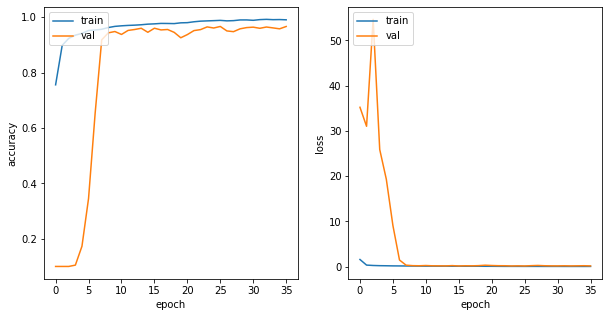

In [ ]:
plot_history(resnet101_history)
resnet101_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

In [ ]:
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet101_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 9882 images belonging to 10 classes.
Global F2 Score: 0.966201173851447


Precision    Recall   F-Score  Support
AnnualCrop             0.983008  0.955409  0.969012   1211.0
Forest                 0.942097  1.000000  0.970185   1204.0
HerbaceousVegetation   0.970339  0.957358  0.963805   1196.0
Highway                0.985690  0.964580  0.975021   1214.0
Industrial             0.978172  0.956000  0.966959    750.0
Pasture                0.985891  0.931667  0.958012    600.0
PermanentCrop          0.926999  0.950119  0.938416    842.0
Residential            0.941121  0.997986  0.968719    993.0
River                  0.956571  0.975524  0.965955    858.0
SeaLake                0.998967  0.953649  0.975782   1014.0

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 98.30    0.23  ...   0.80      0.1
Forest                      0.00   94.21  ...   0.00      0.0
HerbaceousVegetation        0.17    1.17  ...   0.00      0.0
Highway                     0.17    0.00  ...   2.17      0.0
Industrial                  0.08    0.00  ...   0.11      0.0
Pasture                     0.34    1.56  ...   0.23      0.0
PermanentCrop               0.42    0.08  ...   0.00      0.0
Residential                 0.00    0.00  ...   0.00      0.0
River                       0.34    0.00  ...  95.66      0.0
SeaLake                     0.17    2.74  ...   1.03     99.9

[10 rows x 10 columns]

In [ ]:
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                  1157       3  ...      7        1
Forest                         0    1204  ...      0        0
HerbaceousVegetation           2      15  ...      0        0
Highway                        2       0  ...     19        0
Industrial                     1       0  ...      1        0
Pasture                        4      20  ...      2        0
PermanentCrop                  5       1  ...      0        0
Residential                    0       0  ...      0        0
River                          4       0  ...    837        0
SeaLake                        2      35  ...      9      967

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
resnet101_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/ResNet101_eurosat.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# RESNET152

In [ ]:
resnet152_model = compile_model('ResNet152', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
resnet152_model.summary()

234708992/234698864 [==============================] - 3s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
_________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
# First Pretraining the dense layer
resnet152_history = resnet152_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
147/147 [==============================] - 109s 654ms/step - loss: 2.9351 - categorical_accuracy: 0.2171 - val_loss: 1.9273 - val_categorical_accuracy: 0.2479

Epoch 00001: val_categorical_accuracy improved from -inf to 0.24787, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
147/147 [==============================] - 92s 624ms/step - loss: 1.8948 - categorical_accuracy: 0.2710 - val_loss: 1.8484 - val_categorical_accuracy: 0.2727

Epoch 00002: val_categorical_accuracy improved from 0.24787 to 0.27273, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
147/147 [==============================] - 93s 630ms/step - loss: 1.8689 - categorical_accuracy: 0.2768 - val_loss: 1.7895 - val_categorical_accuracy: 0.3145

Epoch 00003: val_categorical_accuracy improved from 0.27273 to 0.31453, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/50
147/147 [==============================] - 96s 650ms/step - loss: 1.8235 - categorical_accuracy: 0.2910 - val_loss: 1.7851 - val_categorical_accuracy: 0.3461

Epoch 00004: val_categorical_accuracy improved from 0.31453 to 0.34608, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weig

In [ ]:
# Re-train whole network end2end 
resnet152_model = compile_model('ResNet152', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

resnet152_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet152_history = resnet152_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
147/147 [==============================] - 160s 959ms/step - loss: 5.6035 - categorical_accuracy: 0.5906 - val_loss: 148.6439 - val_categorical_accuracy: 0.0500

Epoch 00001: val_categorical_accuracy did not improve from 0.46317
Epoch 2/100
147/147 [==============================] - 137s 929ms/step - loss: 0.6550 - categorical_accuracy: 0.8428 - val_loss: 202.9741 - val_categorical_accuracy: 0.0935

Epoch 00002: val_categorical_accuracy did not improve from 0.46317
Epoch 3/100
147/147 [==============================] - 137s 928ms/step - loss: 0.3855 - categorical_accuracy: 0.8939 - val_loss: 778.1868 - val_categorical_accuracy: 0.0442

Epoch 00003: val_categorical_accuracy did not improve from 0.46317
Epoch 4/100
147/147 [==============================] - 136s 925ms/step - loss: 0.3998 - categorical_accuracy: 0.9096 - val_loss: 2079.1296 - val_categorical_accuracy: 0.0387

Epoch 00004: val_categorical_accuracy did not improve from 0.46317
Epoch 5/100
147/147 [==============

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/100
147/147 [==============================] - 137s 930ms/step - loss: 0.2384 - categorical_accuracy: 0.9365 - val_loss: 0.5361 - val_categorical_accuracy: 0.8701

Epoch 00008: val_categorical_accuracy improved from 0.62886 to 0.87013, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 9/100
147/147 [==============================] - 138s 936ms/step - loss: 0.1831 - categorical_accuracy: 0.9407 - val_loss: 0.2419 - val_categorical_accuracy: 0.9300

Epoch 00009: val_categorical_accuracy improved from 0.87013 to 0.92999, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 10/100
147/147 [==============================] - 137s 931ms/step - loss: 0.1626 - categorical_accuracy: 0.9470 - val_loss: 0.2236 - val_categorical_accuracy: 0.9348

Epoch 00010: val_categorical_accuracy improved from 0.92999 to 0.93476, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/mod

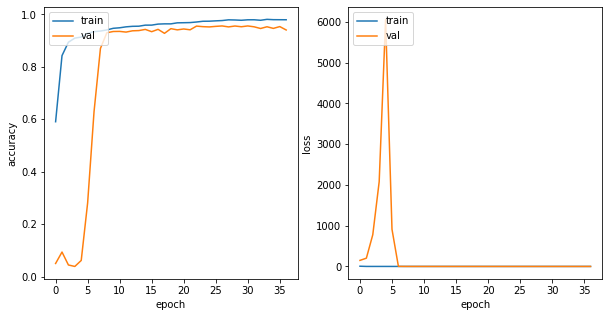

In [ ]:
plot_history(resnet152_history)
resnet152_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

In [ ]:
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet152_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 9882 images belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Global F2 Score: 0.9546650475612225


Precision    Recall   F-Score  Support
AnnualCrop             0.957571  0.950454  0.953999   1211.0
Forest                 0.934681  0.998339  0.965462   1204.0
HerbaceousVegetation   0.973286  0.913880  0.942648   1196.0
Highway                0.976764  0.934926  0.955387   1214.0
Industrial             0.970350  0.960000  0.965147    750.0
Pasture                0.970175  0.921667  0.945299    600.0
PermanentCrop          0.897753  0.948931  0.922633    842.0
Residential            0.916898  1.000000  0.956647    993.0
River                  0.958382  0.966200  0.962275    858.0
SeaLake                1.000000  0.945759  0.972124   1014.0

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 97.24    0.00  ...   0.79      0.0
Forest                      0.00   95.10  ...   0.00      0.0
HerbaceousVegetation        0.25    0.95  ...   0.00      0.0
Highway                     0.59    0.08  ...   3.84      0.0
Industrial                  0.00    0.00  ...   0.00      0.0
Pasture                     0.25    1.58  ...   0.00      0.0
PermanentCrop               0.17    0.08  ...   0.00      0.0
Residential                 0.00    0.00  ...   0.00      0.0
River                       0.17    0.00  ...  94.92      0.0
SeaLake                     1.34    2.21  ...   0.45    100.0

[10 rows x 10 columns]

In [ ]:
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                  1151       1  ...      5        0
Forest                         0    1202  ...      0        0
HerbaceousVegetation           9      19  ...      0        0
Highway                       15       0  ...     23        0
Industrial                     0       0  ...      1        0
Pasture                        6      25  ...      2        0
PermanentCrop                  3       1  ...      1        0
Residential                    0       0  ...      0        0
River                          6       1  ...    829        0
SeaLake                       12      37  ...      4      959

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=1)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 95.05    0.08  ...   0.58     0.00
Forest                      0.00   99.83  ...   0.00     0.00
HerbaceousVegetation        0.74    1.58  ...   0.00     0.00
Highway                     1.24    0.00  ...   2.68     0.00
Industrial                  0.00    0.00  ...   0.12     0.00
Pasture                     0.50    2.08  ...   0.23     0.00
PermanentCrop               0.25    0.08  ...   0.12     0.00
Residential                 0.00    0.00  ...   0.00     0.00
River                       0.50    0.08  ...  96.62     0.00
SeaLake                     0.99    3.07  ...   0.47    94.58

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
resnet152_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/resnet152_eurosat.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# VGG Models

# VGG16 MODEL

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
147/147 [==============================] - 5857s 40s/step - loss: 2.7576 - categorical_accuracy: 0.5458 - val_loss: 0.7675 - val_categorical_accuracy: 0.7399

Epoch 00001: val_categorical_accuracy improved from -inf to 0.73985, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/50
147/147 [==============================] - 69s 471ms/step - loss: 0.9513 - categorical_accuracy: 0.6684 - val_loss: 0.6793 - val_categorical_accuracy: 0.7747

Epoch 00002: val_categorical_accuracy improved from 0.73985 to 0.77466, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
147/147 [==============================] - 67s 459ms/step - loss: 0.9007 - categorical_accuracy: 0.6878 - val_loss: 0.7013 - val_categorical_accuracy: 0.7751

Epoch 00003: val_categorical_accuracy improved from 0.77466 to 0.77506, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights

In [ ]:
# Re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
147/147 [==============================] - 70s 462ms/step - loss: 1.5287 - categorical_accuracy: 0.4825 - val_loss: 1.0133 - val_categorical_accuracy: 0.6666

Epoch 00001: val_categorical_accuracy did not improve from 0.82447
Epoch 2/100
147/147 [==============================] - 67s 459ms/step - loss: 0.7699 - categorical_accuracy: 0.7508 - val_loss: 0.3684 - val_categorical_accuracy: 0.8966

Epoch 00002: val_categorical_accuracy improved from 0.82447 to 0.89661, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/100
147/147 [==============================] - 67s 459ms/step - loss: 0.4968 - categorical_accuracy: 0.8511 - val_loss: 0.7084 - val_categorical_accuracy: 0.7873

Epoch 00003: val_categorical_accuracy did not improve from 0.89661
Epoch 4/100
147/147 [==============================] - 68s 461ms/step - loss: 0.4601 - categorical_accuracy: 0.8653 - val_loss: 0.2246 - val_categorical_accuracy: 0.9367

Epoch 00004: v

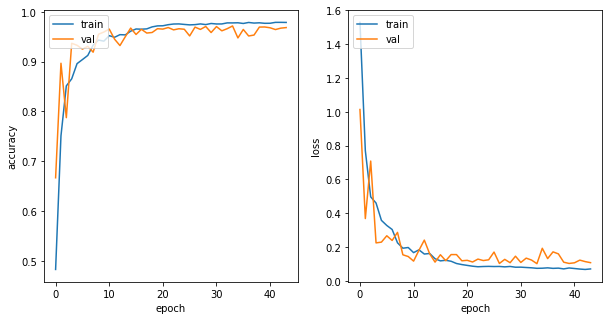

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 9882 images belonging to 10 classes.
Global F2 Score: 0.9705525197328475


Precision    Recall   F-Score  Support
AnnualCrop             0.958191  0.927333  0.942509   1211.0
Forest                 0.978689  0.991694  0.985149   1204.0
HerbaceousVegetation   0.986945  0.948161  0.967164   1196.0
Highway                0.985161  0.984349  0.984755   1214.0
Industrial             0.986468  0.972000  0.979181    750.0
Pasture                0.957586  0.978333  0.967848    600.0
PermanentCrop          0.905724  0.958432  0.931333    842.0
Residential            0.961240  0.998993  0.979753    993.0
River                  0.978972  0.976690  0.977830    858.0
SeaLake                0.994985  0.978304  0.986574   1014.0

In [ ]:
# confusion matrix as values
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                  1123       1  ...      5        4
Forest                         2    1194  ...      0        1
HerbaceousVegetation          13      14  ...      1        0
Highway                        3       0  ...      8        0
Industrial                     3       0  ...      0        0
Pasture                        5       1  ...      0        0
PermanentCrop                 10       0  ...      0        0
Residential                    0       0  ...      0        0
River                          5       1  ...    838        0
SeaLake                        8       9  ...      4      992

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 95.82    0.08  ...   0.58      0.4
Forest                      0.17   97.87  ...   0.00      0.1
HerbaceousVegetation        1.11    1.15  ...   0.12      0.0
Highway                     0.26    0.00  ...   0.93      0.0
Industrial                  0.26    0.00  ...   0.00      0.0
Pasture                     0.43    0.08  ...   0.00      0.0
PermanentCrop               0.85    0.00  ...   0.00      0.0
Residential                 0.00    0.00  ...   0.00      0.0
River                       0.43    0.08  ...  97.90      0.0
SeaLake                     0.68    0.74  ...   0.47     99.5

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/vgg16_eurosat.h5')

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
____________________________________________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=50,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
168/168 [==============================] - 71s 414ms/step - loss: 1.6215 - categorical_accuracy: 0.6419 - val_loss: 1.9639 - val_categorical_accuracy: 0.6382

Epoch 00001: val_categorical_accuracy improved from -inf to 0.63821, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/50
168/168 [==============================] - 69s 412ms/step - loss: 0.8412 - categorical_accuracy: 0.7482 - val_loss: 0.7493 - val_categorical_accuracy: 0.7827

Epoch 00002: val_categorical_accuracy improved from 0.63821 to 0.78274, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
168/168 [==============================] - 68s 405ms/step - loss: 0.7107 - categorical_accuracy: 0.7686 - val_loss: 0.5322 - val_categorical_accuracy: 0.8346

Epoch 00003: val_categorical_accuracy improved from 0.78274 to 0.83464, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights

In [ ]:
# Re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
168/168 [==============================] - 69s 401ms/step - loss: 0.4421 - categorical_accuracy: 0.8527 - val_loss: 8.0490 - val_categorical_accuracy: 0.8385

Epoch 00001: val_categorical_accuracy did not improve from 0.86793
Epoch 2/200
168/168 [==============================] - 67s 399ms/step - loss: 0.2618 - categorical_accuracy: 0.9117 - val_loss: 3.6717 - val_categorical_accuracy: 0.7922

Epoch 00002: val_categorical_accuracy did not improve from 0.86793
Epoch 3/200
168/168 [==============================] - 67s 399ms/step - loss: 0.2290 - categorical_accuracy: 0.9247 - val_loss: 1.4477 - val_categorical_accuracy: 0.9010

Epoch 00003: val_categorical_accuracy improved from 0.86793 to 0.90104, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/200
168/168 [==============================] - 68s 402ms/step - loss: 0.1649 - categorical_accuracy: 0.9448 - val_loss: 0.4118 - val_categorical_accuracy: 0.9286

Epoch 00004: v

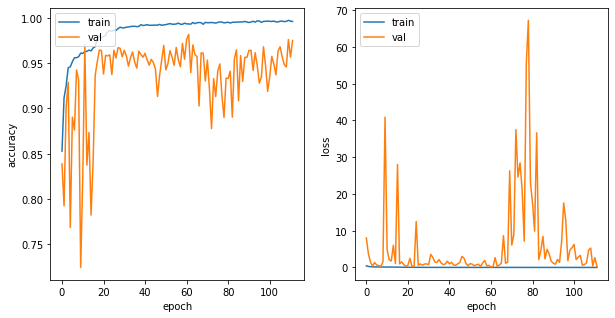

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Global F2 Score: 0.980925925925926


Precision    Recall   F-Score  Support
AnnualCrop             0.984797  0.971667  0.978188    600.0
Forest                 0.991708  0.996667  0.994181    600.0
HerbaceousVegetation   0.988255  0.981667  0.984950    600.0
Highway                0.981781  0.970000  0.975855    500.0
Industrial             0.978088  0.982000  0.980040    500.0
Pasture                0.982368  0.975000  0.978670    400.0
PermanentCrop          0.955734  0.950000  0.952859    500.0
Residential            0.969256  0.998333  0.983580    600.0
River                  0.976285  0.988000  0.982107    500.0
SeaLake                0.996639  0.988333  0.992469    600.0

In [ ]:
# confusion matrix as values
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                   583       0  ...      3        1
Forest                         0     598  ...      0        1
HerbaceousVegetation           2       1  ...      0        0
Highway                        1       0  ...      5        0
Industrial                     0       0  ...      1        0
Pasture                        1       2  ...      0        0
PermanentCrop                  4       1  ...      0        0
Residential                    0       0  ...      0        0
River                          0       0  ...    494        0
SeaLake                        1       1  ...      3      593

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 98.48    0.00  ...   0.59     0.17
Forest                      0.00   99.17  ...   0.00     0.17
HerbaceousVegetation        0.34    0.17  ...   0.00     0.00
Highway                     0.17    0.00  ...   0.99     0.00
Industrial                  0.00    0.00  ...   0.20     0.00
Pasture                     0.17    0.33  ...   0.00     0.00
PermanentCrop               0.68    0.17  ...   0.00     0.00
Residential                 0.00    0.00  ...   0.00     0.00
River                       0.00    0.00  ...  97.63     0.00
SeaLake                     0.17    0.17  ...   0.59    99.66

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/vgg16_eurosat5.h5')

# VGG16 MODEL - Test3 (with Kernel Regularization)




In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
168/168 [==============================] - 56s 318ms/step - loss: 3.2899 - categorical_accuracy: 0.6251 - val_loss: 3.4203 - val_categorical_accuracy: 0.4241

Epoch 00001: val_categorical_accuracy improved from -inf to 0.42411, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/50
168/168 [==============================] - 51s 304ms/step - loss: 1.9795 - categorical_accuracy: 0.7155 - val_loss: 1.6741 - val_categorical_accuracy: 0.6795

Epoch 00002: val_categorical_accuracy improved from 0.42411 to 0.67950, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
168/168 [==============================] - 51s 301ms/step - loss: 1.5500 - categorical_accuracy: 0.7393 - val_loss: 1.3183 - val_categorical_accuracy: 0.7922

Epoch 00003: val_categorical_accuracy improved from 0.67950 to 0.79222, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights

In [ ]:
# Re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
168/168 [==============================] - 54s 308ms/step - loss: 0.6266 - categorical_accuracy: 0.8366 - val_loss: 0.6235 - val_categorical_accuracy: 0.8506

Epoch 00001: val_categorical_accuracy improved from 0.83129 to 0.85063, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/200
168/168 [==============================] - 52s 311ms/step - loss: 0.3821 - categorical_accuracy: 0.9201 - val_loss: 0.4305 - val_categorical_accuracy: 0.9077

Epoch 00002: val_categorical_accuracy improved from 0.85063 to 0.90774, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/200
168/168 [==============================] - 52s 308ms/step - loss: 0.3354 - categorical_accuracy: 0.9340 - val_loss: 0.4940 - val_categorical_accuracy: 0.8782

Epoch 00003: val_categorical_accuracy did not improve from 0.90774
Epoch 4/200
168/168 [==============================] - 51s 303ms/step - loss: 0.3008

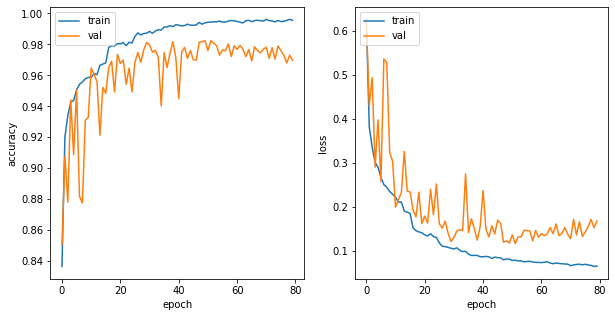

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9814814814814815
Global F2 Score: 0.9814814814814815


Precision    Recall   F-Score  Support
AnnualCrop             0.981419  0.968333  0.974832    600.0
Forest                 0.991722  0.998333  0.995017    600.0
HerbaceousVegetation   0.989848  0.975000  0.982368    600.0
Highway                0.980040  0.982000  0.981019    500.0
Industrial             0.995893  0.970000  0.982776    500.0
Pasture                0.975309  0.987500  0.981366    400.0
PermanentCrop          0.951550  0.982000  0.966535    500.0
Residential            0.969256  0.998333  0.983580    600.0
River                  0.976238  0.986000  0.981095    500.0
SeaLake                1.000000  0.968333  0.983912    600.0

In [ ]:
# confusion matrix as values
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                   581       0  ...      2        0
Forest                         0     599  ...      1        0
HerbaceousVegetation           0       0  ...      0        0
Highway                        2       0  ...      3        0
Industrial                     0       0  ...      0        0
Pasture                        1       1  ...      0        0
PermanentCrop                  1       0  ...      0        0
Residential                    0       0  ...      0        0
River                          0       0  ...    493        0
SeaLake                        7       4  ...      6      581

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 98.14    0.00  ...   0.40      0.0
Forest                      0.00   99.17  ...   0.20      0.0
HerbaceousVegetation        0.00    0.00  ...   0.00      0.0
Highway                     0.34    0.00  ...   0.59      0.0
Industrial                  0.00    0.00  ...   0.00      0.0
Pasture                     0.17    0.17  ...   0.00      0.0
PermanentCrop               0.17    0.00  ...   0.00      0.0
Residential                 0.00    0.00  ...   0.00      0.0
River                       0.00    0.00  ...  97.62      0.0
SeaLake                     1.18    0.66  ...   1.19    100.0

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/vgg16_eurosat7reg.h5')

# VGG16 MODEL - Test4 (Reduce model capacity from 2048 to 1024 units)

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
168/168 [==============================] - 53s 307ms/step - loss: 1.8943 - categorical_accuracy: 0.6537 - val_loss: 1.6758 - val_categorical_accuracy: 0.7266

Epoch 00001: val_categorical_accuracy improved from -inf to 0.72656, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/50
168/168 [==============================] - 51s 306ms/step - loss: 1.2934 - categorical_accuracy: 0.7422 - val_loss: 1.3972 - val_categorical_accuracy: 0.6479

Epoch 00002: val_categorical_accuracy did not improve from 0.72656
Epoch 3/50
168/168 [==============================] - 52s 308ms/step - loss: 1.1208 - categorical_accuracy: 0.7593 - val_loss: 0.9968 - val_categorical_accuracy: 0.8036

Epoch 00003: val_categorical_accuracy improved from 0.72656 to 0.80357, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/50
168/168 [==============================] - 52s 309ms/step - loss: 1.0417 - cate

In [ ]:
# Re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
168/168 [==============================] - 54s 312ms/step - loss: 0.6049 - categorical_accuracy: 0.8448 - val_loss: 0.3449 - val_categorical_accuracy: 0.9299

Epoch 00001: val_categorical_accuracy improved from 0.82906 to 0.92987, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/200
168/168 [==============================] - 53s 313ms/step - loss: 0.3895 - categorical_accuracy: 0.9198 - val_loss: 0.6650 - val_categorical_accuracy: 0.8233

Epoch 00002: val_categorical_accuracy did not improve from 0.92987
Epoch 3/200
168/168 [==============================] - 52s 308ms/step - loss: 0.3527 - categorical_accuracy: 0.9294 - val_loss: 0.3201 - val_categorical_accuracy: 0.9394

Epoch 00003: val_categorical_accuracy improved from 0.92987 to 0.93936, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/200
168/168 [==============================] - 52s 310ms/step - loss: 0.3261

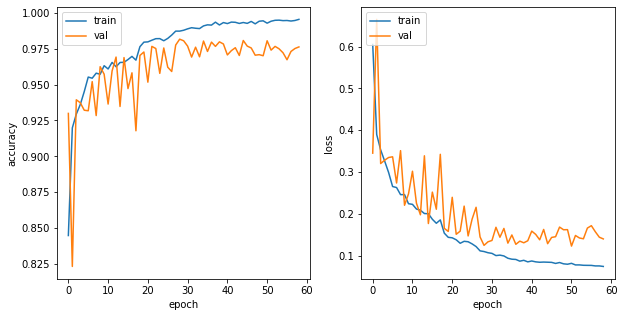

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9811111111111112
Global F2 Score: 0.9811111111111112


Precision    Recall   F-Score  Support
AnnualCrop             0.976471  0.968333  0.972385    600.0
Forest                 0.990099  1.000000  0.995025    600.0
HerbaceousVegetation   0.986441  0.970000  0.978151    600.0
Highway                0.973948  0.972000  0.972973    500.0
Industrial             0.978261  0.990000  0.984095    500.0
Pasture                0.974937  0.972500  0.973717    400.0
PermanentCrop          0.960000  0.960000  0.960000    500.0
Residential            0.986820  0.998333  0.992543    600.0
River                  0.978131  0.984000  0.981057    500.0
SeaLake                0.998319  0.990000  0.994142    600.0

In [ ]:
# confusion matrix as values
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                   581       0  ...      4        1
Forest                         0     600  ...      0        0
HerbaceousVegetation           1       2  ...      0        0
Highway                        3       0  ...      5        0
Industrial                     0       0  ...      0        0
Pasture                        3       2  ...      1        0
PermanentCrop                  4       1  ...      0        0
Residential                    0       0  ...      0        0
River                          0       0  ...    492        0
SeaLake                        3       1  ...      1      594

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 97.65    0.00  ...   0.80     0.17
Forest                      0.00   99.01  ...   0.00     0.00
HerbaceousVegetation        0.17    0.33  ...   0.00     0.00
Highway                     0.50    0.00  ...   0.99     0.00
Industrial                  0.00    0.00  ...   0.00     0.00
Pasture                     0.50    0.33  ...   0.20     0.00
PermanentCrop               0.67    0.17  ...   0.00     0.00
Residential                 0.00    0.00  ...   0.00     0.00
River                       0.00    0.00  ...  97.81     0.00
SeaLake                     0.50    0.17  ...   0.20    99.83

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/vgg16_eurosat8cap_red.h5')

NameError: ignored

# VGG16 MODEL - Test5 (reduce model capacity to 512 units)

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
168/168 [==============================] - 7638s 45s/step - loss: 1.3057 - categorical_accuracy: 0.6802 - val_loss: 1.3278 - val_categorical_accuracy: 0.6864

Epoch 00001: val_categorical_accuracy improved from -inf to 0.68638, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/50
168/168 [==============================] - 71s 422ms/step - loss: 0.9935 - categorical_accuracy: 0.7500 - val_loss: 0.9064 - val_categorical_accuracy: 0.7937

Epoch 00002: val_categorical_accuracy improved from 0.68638 to 0.79371, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
168/168 [==============================] - 69s 414ms/step - loss: 0.8942 - categorical_accuracy: 0.7731 - val_loss: 0.9131 - val_categorical_accuracy: 0.7645

Epoch 00003: val_categorical_accuracy did not improve from 0.79371
Epoch 4/50
168/168 [==============================] - 69s 408ms/step - loss: 0.8647 - cate

In [ ]:
# Re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
168/168 [==============================] - 72s 410ms/step - loss: 0.6742 - categorical_accuracy: 0.8141 - val_loss: 0.7037 - val_categorical_accuracy: 0.8225

Epoch 00001: val_categorical_accuracy did not improve from 0.83891
Epoch 2/200
168/168 [==============================] - 69s 412ms/step - loss: 0.4049 - categorical_accuracy: 0.9099 - val_loss: 0.3142 - val_categorical_accuracy: 0.9353

Epoch 00002: val_categorical_accuracy improved from 0.83891 to 0.93527, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/200
168/168 [==============================] - 69s 409ms/step - loss: 0.3325 - categorical_accuracy: 0.9324 - val_loss: 0.3150 - val_categorical_accuracy: 0.9401

Epoch 00003: val_categorical_accuracy improved from 0.93527 to 0.94010, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/200
168/168 [==============================] - 69s 410ms/step - loss: 0.2963

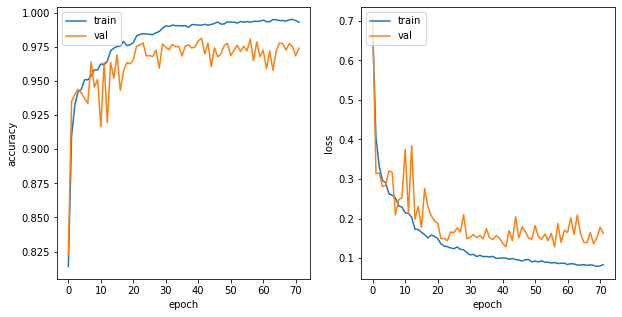

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9812962962962963
Global F2 Score: 0.9812962962962964


Precision    Recall   F-Score  Support
AnnualCrop             0.993162  0.968333  0.980591    600.0
Forest                 0.990099  1.000000  0.995025    600.0
HerbaceousVegetation   0.991482  0.970000  0.980623    600.0
Highway                0.987654  0.960000  0.973631    500.0
Industrial             0.974104  0.978000  0.976048    500.0
Pasture                0.975124  0.980000  0.977556    400.0
PermanentCrop          0.953125  0.976000  0.964427    500.0
Residential            0.963082  1.000000  0.981194    600.0
River                  0.980159  0.988000  0.984064    500.0
SeaLake                1.000000  0.988333  0.994132    600.0

In [ ]:
# confusion matrix as values
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                   581       0  ...      2        0
Forest                         0     600  ...      0        0
HerbaceousVegetation           0       2  ...      0        0
Highway                        1       0  ...      5        0
Industrial                     0       0  ...      0        0
Pasture                        0       3  ...      0        0
PermanentCrop                  1       1  ...      0        0
Residential                    0       0  ...      0        0
River                          0       0  ...    494        0
SeaLake                        2       0  ...      3      593

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 99.32    0.00  ...   0.40      0.0
Forest                      0.00   99.01  ...   0.00      0.0
HerbaceousVegetation        0.00    0.33  ...   0.00      0.0
Highway                     0.17    0.00  ...   0.99      0.0
Industrial                  0.00    0.00  ...   0.00      0.0
Pasture                     0.00    0.50  ...   0.00      0.0
PermanentCrop               0.17    0.17  ...   0.00      0.0
Residential                 0.00    0.00  ...   0.00      0.0
River                       0.00    0.00  ...  98.02      0.0
SeaLake                     0.34    0.00  ...   0.60    100.0

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/vgg16_eurosat9cap_red.h5')

# VGG16 MODEL - Test6 (Activity Regularizer -512 units)

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
168/168 [==============================] - 7536s 45s/step - loss: 1.2475 - categorical_accuracy: 0.6738 - val_loss: 1.5003 - val_categorical_accuracy: 0.5655

Epoch 00001: val_categorical_accuracy improved from -inf to 0.56548, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/50
168/168 [==============================] - 53s 318ms/step - loss: 0.8309 - categorical_accuracy: 0.7399 - val_loss: 0.9056 - val_categorical_accuracy: 0.7520

Epoch 00002: val_categorical_accuracy improved from 0.56548 to 0.75205, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
168/168 [==============================] - 53s 314ms/step - loss: 0.7841 - categorical_accuracy: 0.7520 - val_loss: 3.4375 - val_categorical_accuracy: 0.5134

Epoch 00003: val_categorical_accuracy did not improve from 0.75205
Epoch 4/50
168/168 [==============================] - 51s 306ms/step - loss: 0.7522 - cate

In [ ]:
# Re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
168/168 [==============================] - 58s 318ms/step - loss: 1.1857 - categorical_accuracy: 0.5999 - val_loss: 0.8090 - val_categorical_accuracy: 0.7210

Epoch 00001: val_categorical_accuracy did not improve from 0.86310
Epoch 2/200
168/168 [==============================] - 51s 306ms/step - loss: 0.7030 - categorical_accuracy: 0.7764 - val_loss: 0.6038 - val_categorical_accuracy: 0.8244

Epoch 00002: val_categorical_accuracy did not improve from 0.86310
Epoch 3/200
168/168 [==============================] - 52s 310ms/step - loss: 0.5340 - categorical_accuracy: 0.8390 - val_loss: 0.2472 - val_categorical_accuracy: 0.9475

Epoch 00003: val_categorical_accuracy improved from 0.86310 to 0.94754, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/200
168/168 [==============================] - 53s 312ms/step - loss: 0.4720 - categorical_accuracy: 0.8610 - val_loss: 0.2895 - val_categorical_accuracy: 0.9295

Epoch 00004: v

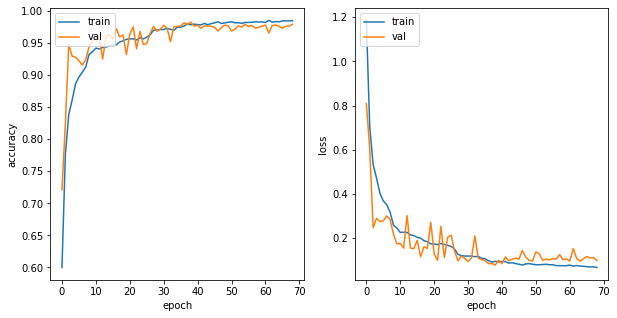

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9816666666666667
Global F2 Score: 0.9816666666666667


Precision    Recall   F-Score  Support
AnnualCrop             0.974747  0.965000  0.969849    600.0
Forest                 0.991708  0.996667  0.994181    600.0
HerbaceousVegetation   0.994872  0.970000  0.982278    600.0
Highway                0.991753  0.962000  0.976650    500.0
Industrial             0.993939  0.984000  0.988945    500.0
Pasture                0.972906  0.987500  0.980149    400.0
PermanentCrop          0.944231  0.982000  0.962745    500.0
Residential            0.975530  0.996667  0.985985    600.0
River                  0.974308  0.986000  0.980119    500.0
SeaLake                0.998314  0.986667  0.992456    600.0

In [ ]:
# confusion matrix as values
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                   579       0  ...      1        1
Forest                         1     598  ...      1        0
HerbaceousVegetation           1       2  ...      0        0
Highway                        4       0  ...      8        0
Industrial                     0       0  ...      1        0
Pasture                        0       0  ...      0        0
PermanentCrop                  3       0  ...      0        0
Residential                    1       0  ...      0        0
River                          3       0  ...    493        0
SeaLake                        2       3  ...      2      592

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 97.47    0.00  ...   0.20     0.17
Forest                      0.17   99.17  ...   0.20     0.00
HerbaceousVegetation        0.17    0.33  ...   0.00     0.00
Highway                     0.67    0.00  ...   1.58     0.00
Industrial                  0.00    0.00  ...   0.20     0.00
Pasture                     0.00    0.00  ...   0.00     0.00
PermanentCrop               0.51    0.00  ...   0.00     0.00
Residential                 0.17    0.00  ...   0.00     0.00
River                       0.51    0.00  ...  97.43     0.00
SeaLake                     0.34    0.50  ...   0.40    99.83

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/vgg16_eurosat6reg_act.h5')

# VGG16 MODEL - Test7 (Activity Regularizer-2048 units)

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
168/168 [==============================] - 6991s 42s/step - loss: 1.9597 - categorical_accuracy: 0.6696 - val_loss: 3.1827 - val_categorical_accuracy: 0.4676

Epoch 00001: val_categorical_accuracy improved from -inf to 0.46763, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/50
168/168 [==============================] - 56s 331ms/step - loss: 0.9175 - categorical_accuracy: 0.7160 - val_loss: 5.0408 - val_categorical_accuracy: 0.4563

Epoch 00002: val_categorical_accuracy did not improve from 0.46763
Epoch 3/50
168/168 [==============================] - 56s 332ms/step - loss: 0.8616 - categorical_accuracy: 0.7347 - val_loss: 1.0586 - val_categorical_accuracy: 0.7558

Epoch 00003: val_categorical_accuracy improved from 0.46763 to 0.75577, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/50
168/168 [==============================] - 55s 328ms/step - loss: 0.8775 - cate

In [ ]:
# Re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
168/168 [==============================] - 59s 325ms/step - loss: 1.0040 - categorical_accuracy: 0.6740 - val_loss: 0.4883 - val_categorical_accuracy: 0.8612

Epoch 00001: val_categorical_accuracy improved from 0.84040 to 0.86124, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/200
168/168 [==============================] - 53s 313ms/step - loss: 0.5817 - categorical_accuracy: 0.8223 - val_loss: 0.2719 - val_categorical_accuracy: 0.9317

Epoch 00002: val_categorical_accuracy improved from 0.86124 to 0.93173, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/200
168/168 [==============================] - 53s 317ms/step - loss: 0.5052 - categorical_accuracy: 0.8534 - val_loss: 0.2242 - val_categorical_accuracy: 0.9440

Epoch 00003: val_categorical_accuracy improved from 0.93173 to 0.94401, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.w

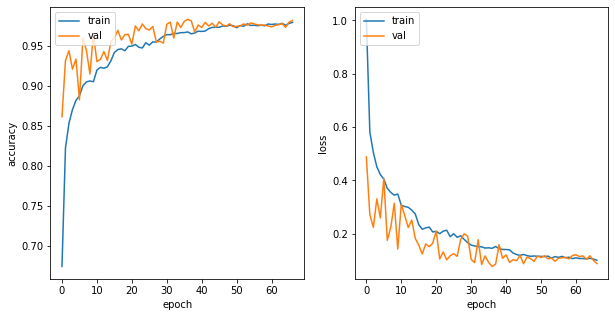

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9827777777777778
Global F2 Score: 0.9827777777777776


Precision    Recall   F-Score  Support
AnnualCrop             0.959416  0.985000  0.972039    600.0
Forest                 0.993355  0.996667  0.995008    600.0
HerbaceousVegetation   0.991394  0.960000  0.975445    600.0
Highway                0.979920  0.976000  0.977956    500.0
Industrial             0.993976  0.990000  0.991984    500.0
Pasture                0.979849  0.972500  0.976161    400.0
PermanentCrop          0.949710  0.982000  0.965585    500.0
Residential            0.988430  0.996667  0.992531    600.0
River                  0.993902  0.978000  0.985887    500.0
SeaLake                0.996633  0.986667  0.991625    600.0

In [ ]:
# confusion matrix as values
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                   591       0  ...      1        1
Forest                         1     598  ...      0        1
HerbaceousVegetation           4       1  ...      0        0
Highway                        2       0  ...      2        0
Industrial                     0       0  ...      0        0
Pasture                        5       1  ...      0        0
PermanentCrop                  4       1  ...      0        0
Residential                    0       0  ...      0        0
River                          4       0  ...    489        0
SeaLake                        5       1  ...      0      592

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 95.94    0.00  ...   0.20     0.17
Forest                      0.16   99.34  ...   0.00     0.17
HerbaceousVegetation        0.65    0.17  ...   0.00     0.00
Highway                     0.32    0.00  ...   0.41     0.00
Industrial                  0.00    0.00  ...   0.00     0.00
Pasture                     0.81    0.17  ...   0.00     0.00
PermanentCrop               0.65    0.17  ...   0.00     0.00
Residential                 0.00    0.00  ...   0.00     0.00
River                       0.65    0.00  ...  99.39     0.00
SeaLake                     0.81    0.17  ...   0.00    99.66

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/vgg16_eurosat7reg_act.h5')

# VGG16 MODEL - Test8 (Activity Regularizer-1024 units)

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
168/168 [==============================] - 56s 329ms/step - loss: 1.5539 - categorical_accuracy: 0.6577 - val_loss: 1.2784 - val_categorical_accuracy: 0.6315

Epoch 00001: val_categorical_accuracy improved from -inf to 0.63151, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/50
168/168 [==============================] - 56s 333ms/step - loss: 0.8704 - categorical_accuracy: 0.7284 - val_loss: 2.5076 - val_categorical_accuracy: 0.5685

Epoch 00002: val_categorical_accuracy did not improve from 0.63151
Epoch 3/50
168/168 [==============================] - 55s 330ms/step - loss: 0.8575 - categorical_accuracy: 0.7307 - val_loss: 1.1053 - val_categorical_accuracy: 0.7258

Epoch 00003: val_categorical_accuracy improved from 0.63151 to 0.72582, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/50
168/168 [==============================] - 55s 330ms/step - loss: 0.7982 - cate

In [ ]:
# Re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
168/168 [==============================] - 57s 334ms/step - loss: 1.0899 - categorical_accuracy: 0.6371 - val_loss: 0.8793 - val_categorical_accuracy: 0.7321

Epoch 00001: val_categorical_accuracy did not improve from 0.84989
Epoch 2/200
168/168 [==============================] - 56s 331ms/step - loss: 0.5983 - categorical_accuracy: 0.8105 - val_loss: 0.4797 - val_categorical_accuracy: 0.8544

Epoch 00002: val_categorical_accuracy improved from 0.84989 to 0.85435, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/200
168/168 [==============================] - 56s 332ms/step - loss: 0.4629 - categorical_accuracy: 0.8689 - val_loss: 0.5441 - val_categorical_accuracy: 0.8439

Epoch 00003: val_categorical_accuracy did not improve from 0.85435
Epoch 4/200
168/168 [==============================] - 55s 329ms/step - loss: 0.4070 - categorical_accuracy: 0.8889 - val_loss: 0.2622 - val_categorical_accuracy: 0.9342

Epoch 00004: v

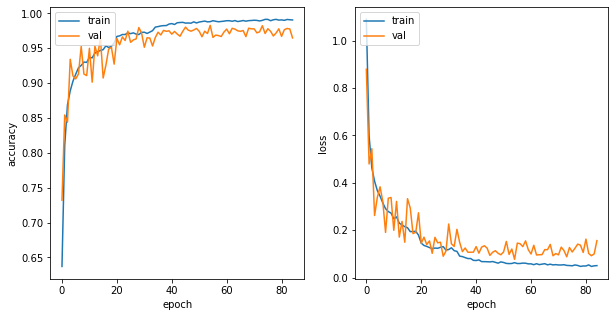

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9827777777777778
Global F2 Score: 0.9827777777777776


Precision    Recall   F-Score  Support
AnnualCrop             0.984925  0.980000  0.982456    600.0
Forest                 0.981997  1.000000  0.990917    600.0
HerbaceousVegetation   0.991482  0.970000  0.980623    600.0
Highway                0.974206  0.982000  0.978088    500.0
Industrial             0.991870  0.976000  0.983871    500.0
Pasture                0.984848  0.975000  0.979899    400.0
PermanentCrop          0.964497  0.978000  0.971202    500.0
Residential            0.969256  0.998333  0.983580    600.0
River                  0.985915  0.980000  0.982949    500.0
SeaLake                0.998308  0.983333  0.990764    600.0

In [ ]:
# confusion matrix as values
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                   588       0  ...      2        1
Forest                         0     600  ...      0        0
HerbaceousVegetation           1       3  ...      0        0
Highway                        0       0  ...      4        0
Industrial                     0       0  ...      0        0
Pasture                        2       3  ...      0        0
PermanentCrop                  2       0  ...      0        0
Residential                    0       0  ...      0        0
River                          2       0  ...    490        0
SeaLake                        2       5  ...      1      590

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 98.49    0.00  ...   0.40     0.17
Forest                      0.00   98.20  ...   0.00     0.00
HerbaceousVegetation        0.17    0.49  ...   0.00     0.00
Highway                     0.00    0.00  ...   0.80     0.00
Industrial                  0.00    0.00  ...   0.00     0.00
Pasture                     0.34    0.49  ...   0.00     0.00
PermanentCrop               0.34    0.00  ...   0.00     0.00
Residential                 0.00    0.00  ...   0.00     0.00
River                       0.34    0.00  ...  98.59     0.00
SeaLake                     0.34    0.82  ...   0.20    99.83

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/vgg16_eurosat8reg_act.h5')

# VGG16 MODEL - Test8b (Activity Regularizer-1024 units, Batchsize =64)

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
337/337 [==============================] - 7824s 23s/step - loss: 1.4162 - categorical_accuracy: 0.6484 - val_loss: 1.5539 - val_categorical_accuracy: 0.5785

Epoch 00001: val_categorical_accuracy improved from -inf to 0.57850, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/50
337/337 [==============================] - 72s 213ms/step - loss: 0.9935 - categorical_accuracy: 0.6875 - val_loss: 1.0997 - val_categorical_accuracy: 0.6700

Epoch 00002: val_categorical_accuracy improved from 0.57850 to 0.67001, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
337/337 [==============================] - 71s 212ms/step - loss: 0.9074 - categorical_accuracy: 0.7093 - val_loss: 0.9936 - val_categorical_accuracy: 0.7409

Epoch 00003: val_categorical_accuracy improved from 0.67001 to 0.74089, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights

In [ ]:
# Re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
337/337 [==============================] - 72s 205ms/step - loss: 1.0160 - categorical_accuracy: 0.6791 - val_loss: 1.1513 - val_categorical_accuracy: 0.6350

Epoch 00001: val_categorical_accuracy did not improve from 0.84542
Epoch 2/200
337/337 [==============================] - 69s 204ms/step - loss: 0.6269 - categorical_accuracy: 0.8107 - val_loss: 0.2745 - val_categorical_accuracy: 0.9351

Epoch 00002: val_categorical_accuracy improved from 0.84542 to 0.93508, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/200
337/337 [==============================] - 70s 209ms/step - loss: 0.4846 - categorical_accuracy: 0.8655 - val_loss: 0.3642 - val_categorical_accuracy: 0.9116

Epoch 00003: val_categorical_accuracy did not improve from 0.93508
Epoch 4/200
337/337 [==============================] - 69s 204ms/step - loss: 0.4234 - categorical_accuracy: 0.8878 - val_loss: 0.3978 - val_categorical_accuracy: 0.9016

Epoch 00004: v

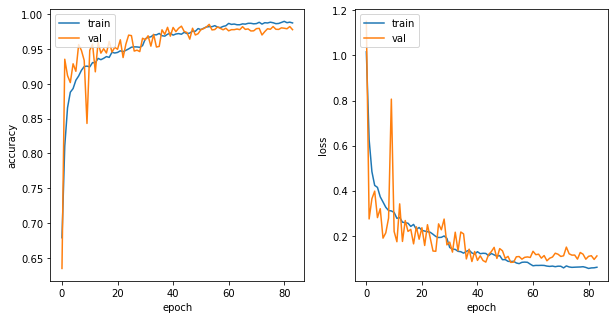

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9846296296296296
Global F2 Score: 0.9846296296296296


Precision    Recall   F-Score  Support
AnnualCrop             0.984772  0.970000  0.977330    600.0
Forest                 0.996667  0.996667  0.996667    600.0
HerbaceousVegetation   0.991525  0.975000  0.983193    600.0
Highway                0.979879  0.974000  0.976931    500.0
Industrial             0.982000  0.982000  0.982000    500.0
Pasture                0.970588  0.990000  0.980198    400.0
PermanentCrop          0.958904  0.980000  0.969337    500.0
Residential            0.985173  0.996667  0.990886    600.0
River                  0.991935  0.984000  0.987952    500.0
SeaLake                0.996667  0.996667  0.996667    600.0

In [ ]:
# confusion matrix as values
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                   582       0  ...      2        1
Forest                         1     598  ...      0        1
HerbaceousVegetation           1       1  ...      0        0
Highway                        2       0  ...      2        0
Industrial                     0       0  ...      0        0
Pasture                        1       1  ...      0        0
PermanentCrop                  2       0  ...      0        0
Residential                    0       0  ...      0        0
River                          1       0  ...    492        0
SeaLake                        1       0  ...      0      598

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 98.48    0.00  ...   0.40     0.17
Forest                      0.17   99.67  ...   0.00     0.17
HerbaceousVegetation        0.17    0.17  ...   0.00     0.00
Highway                     0.34    0.00  ...   0.40     0.00
Industrial                  0.00    0.00  ...   0.00     0.00
Pasture                     0.17    0.17  ...   0.00     0.00
PermanentCrop               0.34    0.00  ...   0.00     0.00
Residential                 0.00    0.00  ...   0.00     0.00
River                       0.17    0.00  ...  99.19     0.00
SeaLake                     0.17    0.00  ...   0.00    99.67

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/vgg16_eurosat8breg_act_batch64.h5')

# VGG16 MODEL - Test9 (Activity Regularizer-4096 units)

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
168/168 [==============================] - 6997s 42s/step - loss: 3.2275 - categorical_accuracy: 0.6462 - val_loss: 4.1021 - val_categorical_accuracy: 0.4658

Epoch 00001: val_categorical_accuracy improved from -inf to 0.46577, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/50
168/168 [==============================] - 52s 312ms/step - loss: 1.0036 - categorical_accuracy: 0.7002 - val_loss: 2.3619 - val_categorical_accuracy: 0.5848

Epoch 00002: val_categorical_accuracy improved from 0.46577 to 0.58482, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
168/168 [==============================] - 52s 310ms/step - loss: 0.9299 - categorical_accuracy: 0.7134 - val_loss: 1.8979 - val_categorical_accuracy: 0.5525

Epoch 00003: val_categorical_accuracy did not improve from 0.58482
Epoch 4/50
168/168 [==============================] - 51s 303ms/step - loss: 0.8929 - cate

In [ ]:
# Re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
168/168 [==============================] - 59s 321ms/step - loss: 1.2267 - categorical_accuracy: 0.6325 - val_loss: 1.1607 - val_categorical_accuracy: 0.5794

Epoch 00001: val_categorical_accuracy did not improve from 0.83668
Epoch 2/200
168/168 [==============================] - 52s 308ms/step - loss: 0.7805 - categorical_accuracy: 0.7483 - val_loss: 0.7423 - val_categorical_accuracy: 0.7982

Epoch 00002: val_categorical_accuracy did not improve from 0.83668
Epoch 3/200
168/168 [==============================] - 52s 309ms/step - loss: 0.5782 - categorical_accuracy: 0.8280 - val_loss: 0.4483 - val_categorical_accuracy: 0.8802

Epoch 00003: val_categorical_accuracy improved from 0.83668 to 0.88021, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/200
168/168 [==============================] - 53s 316ms/step - loss: 0.5044 - categorical_accuracy: 0.8541 - val_loss: 0.4513 - val_categorical_accuracy: 0.8824

Epoch 00004: v

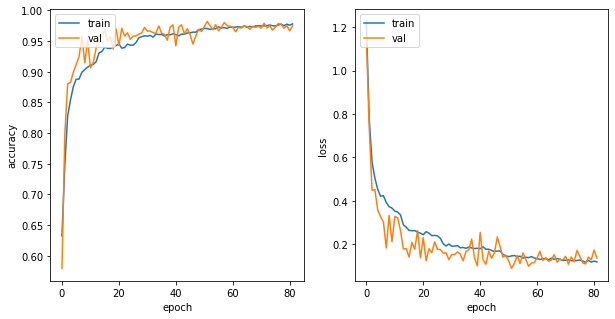

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9812962962962963
Global F2 Score: 0.9812962962962964


Precision    Recall   F-Score  Support
AnnualCrop             0.973466  0.978333  0.975894    600.0
Forest                 0.998319  0.990000  0.994142    600.0
HerbaceousVegetation   0.986441  0.970000  0.978151    600.0
Highway                0.985567  0.956000  0.970558    500.0
Industrial             0.978131  0.984000  0.981057    500.0
Pasture                0.977556  0.980000  0.978777    400.0
PermanentCrop          0.962451  0.974000  0.968191    500.0
Residential            0.970779  0.996667  0.983553    600.0
River                  0.980159  0.988000  0.984064    500.0
SeaLake                0.996650  0.991667  0.994152    600.0

In [ ]:
# confusion matrix as values
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                   587       0  ...      2        1
Forest                         3     594  ...      0        1
HerbaceousVegetation           0       0  ...      1        0
Highway                        6       0  ...      7        0
Industrial                     0       0  ...      0        0
Pasture                        0       1  ...      0        0
PermanentCrop                  2       0  ...      0        0
Residential                    0       0  ...      0        0
River                          1       0  ...    494        0
SeaLake                        4       0  ...      0      595

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 97.35    0.00  ...   0.40     0.17
Forest                      0.50   99.83  ...   0.00     0.17
HerbaceousVegetation        0.00    0.00  ...   0.20     0.00
Highway                     1.00    0.00  ...   1.39     0.00
Industrial                  0.00    0.00  ...   0.00     0.00
Pasture                     0.00    0.17  ...   0.00     0.00
PermanentCrop               0.33    0.00  ...   0.00     0.00
Residential                 0.00    0.00  ...   0.00     0.00
River                       0.17    0.00  ...  98.02     0.00
SeaLake                     0.66    0.00  ...   0.00    99.66

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/vgg16_eurosat9reg_act.h5')

# VGG16 MODEL - Test10 (Activity Regularizer-1024 units, Droput rate 0.5)

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
168/168 [==============================] - 8294s 49s/step - loss: 1.9008 - categorical_accuracy: 0.6051 - val_loss: 1.0331 - val_categorical_accuracy: 0.7541

Epoch 00001: val_categorical_accuracy improved from -inf to 0.75409, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/50
168/168 [==============================] - 51s 306ms/step - loss: 1.1280 - categorical_accuracy: 0.6670 - val_loss: 1.0024 - val_categorical_accuracy: 0.7474

Epoch 00002: val_categorical_accuracy did not improve from 0.75409
Epoch 3/50
168/168 [==============================] - 50s 300ms/step - loss: 1.0743 - categorical_accuracy: 0.6709 - val_loss: 1.0817 - val_categorical_accuracy: 0.7137

Epoch 00003: val_categorical_accuracy did not improve from 0.75409
Epoch 4/50
168/168 [==============================] - 51s 304ms/step - loss: 1.0513 - categorical_accuracy: 0.6774 - val_loss: 735.2172 - val_categorical_accuracy: 0.0951

Epoch 00004: val_ca

In [ ]:
# Re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
168/168 [==============================] - 57s 313ms/step - loss: 1.1648 - categorical_accuracy: 0.6440 - val_loss: 0.7452 - val_categorical_accuracy: 0.7751

Epoch 00001: val_categorical_accuracy did not improve from 0.83780
Epoch 2/200
168/168 [==============================] - 51s 306ms/step - loss: 0.6826 - categorical_accuracy: 0.8111 - val_loss: 0.5397 - val_categorical_accuracy: 0.8575

Epoch 00002: val_categorical_accuracy improved from 0.83780 to 0.85751, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/200
168/168 [==============================] - 51s 305ms/step - loss: 0.5613 - categorical_accuracy: 0.8490 - val_loss: 0.3945 - val_categorical_accuracy: 0.8994

Epoch 00003: val_categorical_accuracy improved from 0.85751 to 0.89937, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/200
168/168 [==============================] - 52s 309ms/step - loss: 0.5217

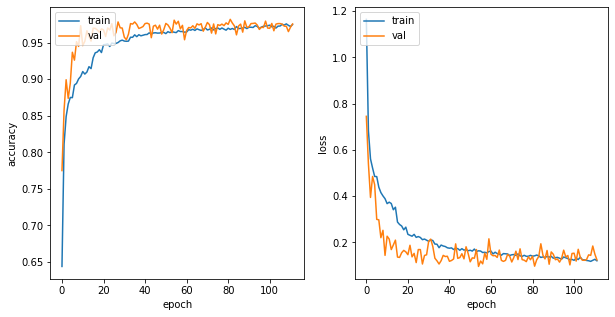

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9816666666666667
Global F2 Score: 0.9816666666666667


Precision    Recall   F-Score  Support
AnnualCrop             0.978224  0.973333  0.975773    600.0
Forest                 0.986777  0.995000  0.990871    600.0
HerbaceousVegetation   0.984589  0.958333  0.971284    600.0
Highway                0.987928  0.982000  0.984955    500.0
Industrial             0.991952  0.986000  0.988967    500.0
Pasture                0.982234  0.967500  0.974811    400.0
PermanentCrop          0.943798  0.974000  0.958661    500.0
Residential            0.981938  0.996667  0.989247    600.0
River                  0.978346  0.994000  0.986111    500.0
SeaLake                0.998314  0.986667  0.992456    600.0

In [ ]:
# confusion matrix as values
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                   584       0  ...      3        0
Forest                         0     597  ...      1        1
HerbaceousVegetation           3       4  ...      0        0
Highway                        2       0  ...      4        0
Industrial                     0       0  ...      0        0
Pasture                        3       1  ...      0        0
PermanentCrop                  4       1  ...      0        0
Residential                    0       0  ...      0        0
River                          0       0  ...    497        0
SeaLake                        1       2  ...      3      592

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 97.82    0.00  ...   0.59     0.00
Forest                      0.00   98.68  ...   0.20     0.17
HerbaceousVegetation        0.50    0.66  ...   0.00     0.00
Highway                     0.34    0.00  ...   0.79     0.00
Industrial                  0.00    0.00  ...   0.00     0.00
Pasture                     0.50    0.17  ...   0.00     0.00
PermanentCrop               0.67    0.17  ...   0.00     0.00
Residential                 0.00    0.00  ...   0.00     0.00
River                       0.00    0.00  ...  97.83     0.00
SeaLake                     0.17    0.33  ...   0.59    99.83

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/vgg16_eurosat10reg_act_drophalf.h5')

# VGG16 MODEL - Test13 (Activity Regularizer-1024 units, Droput rate 0.3)

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
168/168 [==============================] - 52s 304ms/step - loss: 1.5284 - categorical_accuracy: 0.6537 - val_loss: 1.6427 - val_categorical_accuracy: 0.6217

Epoch 00001: val_categorical_accuracy improved from -inf to 0.62165, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/50
168/168 [==============================] - 51s 304ms/step - loss: 0.9195 - categorical_accuracy: 0.7183 - val_loss: 1.3873 - val_categorical_accuracy: 0.6499

Epoch 00002: val_categorical_accuracy improved from 0.62165 to 0.64993, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
168/168 [==============================] - 51s 302ms/step - loss: 0.8749 - categorical_accuracy: 0.7302 - val_loss: 0.7851 - val_categorical_accuracy: 0.7855

Epoch 00003: val_categorical_accuracy improved from 0.64993 to 0.78553, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights

In [ ]:
# Re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
168/168 [==============================] - 52s 301ms/step - loss: 1.3901 - categorical_accuracy: 0.5714 - val_loss: 0.6815 - val_categorical_accuracy: 0.7941

Epoch 00001: val_categorical_accuracy did not improve from 0.85640
Epoch 2/200
168/168 [==============================] - 51s 305ms/step - loss: 0.5591 - categorical_accuracy: 0.8454 - val_loss: 0.3940 - val_categorical_accuracy: 0.8973

Epoch 00002: val_categorical_accuracy improved from 0.85640 to 0.89732, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/200
168/168 [==============================] - 52s 310ms/step - loss: 0.4651 - categorical_accuracy: 0.8789 - val_loss: 0.2913 - val_categorical_accuracy: 0.9224

Epoch 00003: val_categorical_accuracy improved from 0.89732 to 0.92243, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/200
168/168 [==============================] - 51s 305ms/step - loss: 0.3880

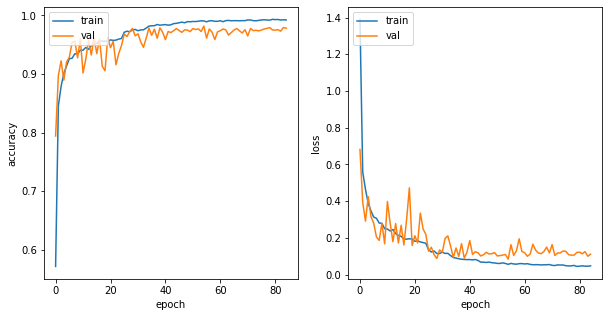

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9812962962962963
Global F2 Score: 0.9812962962962964


Precision    Recall   F-Score  Support
AnnualCrop             0.971667  0.971667  0.971667    600.0
Forest                 0.993333  0.993333  0.993333    600.0
HerbaceousVegetation   0.989673  0.958333  0.973751    600.0
Highway                0.987830  0.974000  0.980866    500.0
Industrial             0.987952  0.984000  0.985972    500.0
Pasture                0.975248  0.985000  0.980100    400.0
PermanentCrop          0.936660  0.976000  0.955926    500.0
Residential            0.981967  0.998333  0.990083    600.0
River                  0.987976  0.986000  0.986987    500.0
SeaLake                0.996633  0.986667  0.991625    600.0

In [ ]:
# confusion matrix as values
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                   583       0  ...      2        1
Forest                         2     596  ...      1        1
HerbaceousVegetation           2       1  ...      0        0
Highway                        3       0  ...      3        0
Industrial                     0       0  ...      0        0
Pasture                        1       2  ...      0        0
PermanentCrop                  3       0  ...      0        0
Residential                    0       0  ...      0        0
River                          2       0  ...    493        0
SeaLake                        4       1  ...      0      592

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 97.17    0.00  ...    0.4     0.17
Forest                      0.33   99.33  ...    0.2     0.17
HerbaceousVegetation        0.33    0.17  ...    0.0     0.00
Highway                     0.50    0.00  ...    0.6     0.00
Industrial                  0.00    0.00  ...    0.0     0.00
Pasture                     0.17    0.33  ...    0.0     0.00
PermanentCrop               0.50    0.00  ...    0.0     0.00
Residential                 0.00    0.00  ...    0.0     0.00
River                       0.33    0.00  ...   98.8     0.00
SeaLake                     0.67    0.17  ...    0.0    99.66

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/vgg16_eurosat13reg_act_droppt3.h5')

# VGG16 MODEL - Test11 (Activity Regularizer-1024 units, Droput rate 0.4)

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
168/168 [==============================] - 52s 306ms/step - loss: 1.6766 - categorical_accuracy: 0.6338 - val_loss: 1.1675 - val_categorical_accuracy: 0.7279

Epoch 00001: val_categorical_accuracy improved from -inf to 0.72786, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/50
168/168 [==============================] - 51s 303ms/step - loss: 1.0345 - categorical_accuracy: 0.6809 - val_loss: 1.0049 - val_categorical_accuracy: 0.6923

Epoch 00002: val_categorical_accuracy did not improve from 0.72786
Epoch 3/50
168/168 [==============================] - 51s 301ms/step - loss: 0.9804 - categorical_accuracy: 0.6895 - val_loss: 0.8124 - val_categorical_accuracy: 0.7697

Epoch 00003: val_categorical_accuracy improved from 0.72786 to 0.76972, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/50
168/168 [==============================] - 51s 305ms/step - loss: 0.9535 - cate

In [ ]:
# Re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
168/168 [==============================] - 54s 311ms/step - loss: 1.4729 - categorical_accuracy: 0.5165 - val_loss: 0.8194 - val_categorical_accuracy: 0.7180

Epoch 00001: val_categorical_accuracy did not improve from 0.85249
Epoch 2/200
168/168 [==============================] - 53s 313ms/step - loss: 0.7875 - categorical_accuracy: 0.7558 - val_loss: 0.5203 - val_categorical_accuracy: 0.8707

Epoch 00002: val_categorical_accuracy improved from 0.85249 to 0.87072, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/200
168/168 [==============================] - 53s 315ms/step - loss: 0.6191 - categorical_accuracy: 0.8233 - val_loss: 0.4833 - val_categorical_accuracy: 0.8722

Epoch 00003: val_categorical_accuracy improved from 0.87072 to 0.87221, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/200
168/168 [==============================] - 53s 315ms/step - loss: 0.5241

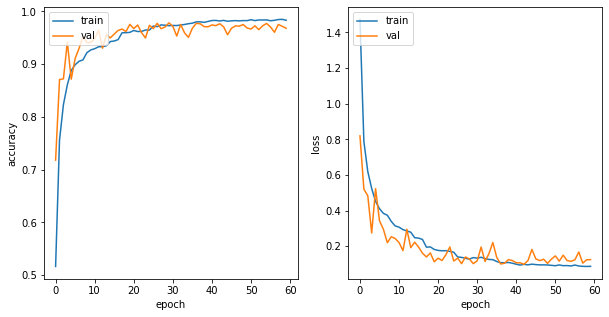

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9774074074074074
Global F2 Score: 0.9774074074074075


Precision    Recall   F-Score  Support
AnnualCrop             0.982993  0.963333  0.973064    600.0
Forest                 0.960000  1.000000  0.979592    600.0
HerbaceousVegetation   0.989691  0.960000  0.974619    600.0
Highway                0.989733  0.964000  0.976697    500.0
Industrial             0.993939  0.984000  0.988945    500.0
Pasture                0.975000  0.975000  0.975000    400.0
PermanentCrop          0.940270  0.976000  0.957802    500.0
Residential            0.975570  0.998333  0.986820    600.0
River                  0.970646  0.992000  0.981207    500.0
SeaLake                0.996546  0.961667  0.978796    600.0

In [ ]:
# confusion matrix as values
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                   578       1  ...      2        2
Forest                         0     600  ...      0        0
HerbaceousVegetation           0       6  ...      0        0
Highway                        4       0  ...      7        0
Industrial                     1       0  ...      0        0
Pasture                        0       6  ...      0        0
PermanentCrop                  4       1  ...      0        0
Residential                    0       0  ...      0        0
River                          0       0  ...    496        0
SeaLake                        1      11  ...      6      577

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 98.30    0.16  ...   0.39     0.35
Forest                      0.00   96.00  ...   0.00     0.00
HerbaceousVegetation        0.00    0.96  ...   0.00     0.00
Highway                     0.68    0.00  ...   1.37     0.00
Industrial                  0.17    0.00  ...   0.00     0.00
Pasture                     0.00    0.96  ...   0.00     0.00
PermanentCrop               0.68    0.16  ...   0.00     0.00
Residential                 0.00    0.00  ...   0.00     0.00
River                       0.00    0.00  ...  97.06     0.00
SeaLake                     0.17    1.76  ...   1.17    99.65

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/vgg16_eurosat11reg_act_droppt4.h5')

# VGG16 MODEL - Test16 (Activity Regularizer-1024 units, Droput rate 0.2, add 1 set [Dense, BN, Dropout])

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
168/168 [==============================] - 55s 323ms/step - loss: 2.0704 - categorical_accuracy: 0.6293 - val_loss: 1.6235 - val_categorical_accuracy: 0.5683

Epoch 00001: val_categorical_accuracy improved from -inf to 0.56827, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/50
168/168 [==============================] - 53s 316ms/step - loss: 0.9689 - categorical_accuracy: 0.7111 - val_loss: 1.5996 - val_categorical_accuracy: 0.5143

Epoch 00002: val_categorical_accuracy did not improve from 0.56827
Epoch 3/50
168/168 [==============================] - 52s 309ms/step - loss: 0.9200 - categorical_accuracy: 0.7239 - val_loss: 1.5298 - val_categorical_accuracy: 0.5863

Epoch 00003: val_categorical_accuracy improved from 0.56827 to 0.58631, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/50
168/168 [==============================] - 53s 313ms/step - loss: 0.8939 - cate

In [ ]:
# Re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
168/168 [==============================] - 54s 314ms/step - loss: 2.1038 - categorical_accuracy: 0.3861 - val_loss: 3.2036 - val_categorical_accuracy: 0.2342

Epoch 00001: val_categorical_accuracy did not improve from 0.85268
Epoch 2/200
168/168 [==============================] - 52s 310ms/step - loss: 1.1338 - categorical_accuracy: 0.6160 - val_loss: 0.8095 - val_categorical_accuracy: 0.7411

Epoch 00002: val_categorical_accuracy did not improve from 0.85268
Epoch 3/200
168/168 [==============================] - 53s 313ms/step - loss: 0.8537 - categorical_accuracy: 0.7278 - val_loss: 0.4641 - val_categorical_accuracy: 0.8756

Epoch 00003: val_categorical_accuracy improved from 0.85268 to 0.87556, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/200
168/168 [==============================] - 53s 315ms/step - loss: 0.6986 - categorical_accuracy: 0.7889 - val_loss: 0.5518 - val_categorical_accuracy: 0.8344

Epoch 00004: v

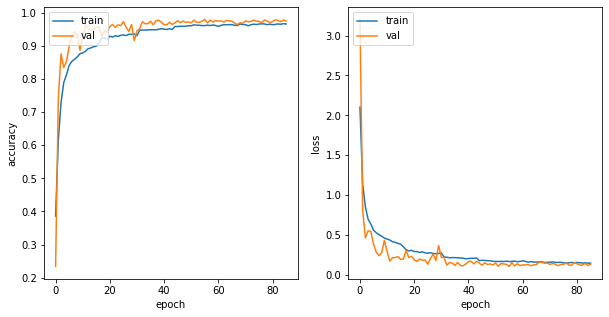

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9792592592592593
Global F2 Score: 0.9792592592592592


Precision    Recall   F-Score  Support
AnnualCrop             0.976744  0.980000  0.978369    600.0
Forest                 0.983607  1.000000  0.991736    600.0
HerbaceousVegetation   0.976628  0.975000  0.975813    600.0
Highway                0.983903  0.978000  0.980943    500.0
Industrial             1.000000  0.942000  0.970134    500.0
Pasture                0.972637  0.977500  0.975062    400.0
PermanentCrop          0.977413  0.952000  0.964539    500.0
Residential            0.946288  0.998333  0.971614    600.0
River                  0.982143  0.990000  0.986056    500.0
SeaLake                0.998319  0.990000  0.994142    600.0

In [ ]:
# confusion matrix as values
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                   588       0  ...      1        1
Forest                         0     600  ...      0        0
HerbaceousVegetation           2       2  ...      0        0
Highway                        2       0  ...      7        0
Industrial                     1       0  ...      1        0
Pasture                        2       3  ...      0        0
PermanentCrop                  6       1  ...      0        0
Residential                    0       0  ...      0        0
River                          0       0  ...    495        0
SeaLake                        1       4  ...      0      594

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 97.67    0.00  ...   0.20     0.17
Forest                      0.00   98.36  ...   0.00     0.00
HerbaceousVegetation        0.33    0.33  ...   0.00     0.00
Highway                     0.33    0.00  ...   1.39     0.00
Industrial                  0.17    0.00  ...   0.20     0.00
Pasture                     0.33    0.49  ...   0.00     0.00
PermanentCrop               1.00    0.16  ...   0.00     0.00
Residential                 0.00    0.00  ...   0.00     0.00
River                       0.00    0.00  ...  98.21     0.00
SeaLake                     0.17    0.66  ...   0.00    99.83

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/vgg16_eurosat16reg_act_layers1.h5')

# VGG16 MODEL - Test17 (Activity Regularizer-1024 units, Droput rate 0.2])

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
168/168 [==============================] - 56s 325ms/step - loss: 1.4549 - categorical_accuracy: 0.6755 - val_loss: 1.0025 - val_categorical_accuracy: 0.7333

Epoch 00001: val_categorical_accuracy improved from -inf to 0.73326, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/50
168/168 [==============================] - 53s 316ms/step - loss: 0.8676 - categorical_accuracy: 0.7320 - val_loss: 3.0233 - val_categorical_accuracy: 0.4462

Epoch 00002: val_categorical_accuracy did not improve from 0.73326
Epoch 3/50
168/168 [==============================] - 52s 310ms/step - loss: 0.8259 - categorical_accuracy: 0.7417 - val_loss: 0.7996 - val_categorical_accuracy: 0.7926

Epoch 00003: val_categorical_accuracy improved from 0.73326 to 0.79260, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/50
168/168 [==============================] - 52s 310ms/step - loss: 0.7987 - cate

In [ ]:
# Re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
168/168 [==============================] - 53s 308ms/step - loss: 0.8388 - categorical_accuracy: 0.7460 - val_loss: 0.5407 - val_categorical_accuracy: 0.8482

Epoch 00001: val_categorical_accuracy did not improve from 0.85584
Epoch 2/200
168/168 [==============================] - 52s 308ms/step - loss: 0.4496 - categorical_accuracy: 0.8758 - val_loss: 0.3016 - val_categorical_accuracy: 0.9163

Epoch 00002: val_categorical_accuracy improved from 0.85584 to 0.91629, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/200
168/168 [==============================] - 52s 311ms/step - loss: 0.3608 - categorical_accuracy: 0.9086 - val_loss: 0.2825 - val_categorical_accuracy: 0.9302

Epoch 00003: val_categorical_accuracy improved from 0.91629 to 0.93025, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/200
168/168 [==============================] - 52s 312ms/step - loss: 0.3131

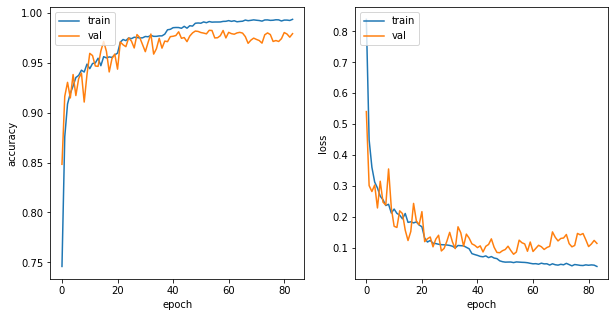

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9814814814814815
Global F2 Score: 0.9814814814814815


Precision    Recall   F-Score  Support
AnnualCrop             0.975329  0.988333  0.981788    600.0
Forest                 0.983607  1.000000  0.991736    600.0
HerbaceousVegetation   0.991394  0.960000  0.975445    600.0
Highway                0.987730  0.966000  0.976744    500.0
Industrial             0.976143  0.982000  0.979063    500.0
Pasture                0.977500  0.977500  0.977500    400.0
PermanentCrop          0.962151  0.966000  0.964072    500.0
Residential            0.978723  0.996667  0.987614    600.0
River                  0.980159  0.988000  0.984064    500.0
SeaLake                0.998311  0.985000  0.991611    600.0

In [ ]:
# confusion matrix as values
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                   593       0  ...      2        1
Forest                         0     600  ...      0        0
HerbaceousVegetation           1       3  ...      0        0
Highway                        2       0  ...      5        0
Industrial                     0       0  ...      1        0
Pasture                        1       4  ...      0        0
PermanentCrop                  6       1  ...      0        0
Residential                    0       0  ...      0        0
River                          1       0  ...    494        0
SeaLake                        4       2  ...      2      591

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 97.53    0.00  ...   0.40     0.17
Forest                      0.00   98.36  ...   0.00     0.00
HerbaceousVegetation        0.16    0.49  ...   0.00     0.00
Highway                     0.33    0.00  ...   0.99     0.00
Industrial                  0.00    0.00  ...   0.20     0.00
Pasture                     0.16    0.66  ...   0.00     0.00
PermanentCrop               0.99    0.16  ...   0.00     0.00
Residential                 0.00    0.00  ...   0.00     0.00
River                       0.16    0.00  ...  98.02     0.00
SeaLake                     0.66    0.33  ...   0.40    99.83

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/vgg16_eurosat17reg_act_droppt2.h5')

# VGG19 MODEL

In [ ]:
vgg19_model = compile_model('VGG19', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg19_model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
model_path = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path,
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
# Execute one time ONLY
train_generator.reset()
# First Pretraining the dense layer
vgg19_history = vgg19_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
147/147 [==============================] - 6278s 43s/step - loss: 3.4014 - categorical_accuracy: 0.4784 - val_loss: 1.0450 - val_categorical_accuracy: 0.6263

Epoch 00001: val_categorical_accuracy improved from -inf to 0.62632, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 2/50
147/147 [==============================] - 87s 595ms/step - loss: 1.1579 - categorical_accuracy: 0.5815 - val_loss: 0.9849 - val_categorical_accuracy: 0.6571

Epoch 00002: val_categorical_accuracy improved from 0.62632 to 0.65706, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
147/147 [==============================] - 86s 582ms/step - loss: 1.0903 - categorical_accuracy: 0.6066 - val_loss: 0.8575 - val_categorical_accuracy: 0.6960

Epoch 00003: val_categorical_accuracy improved from 0.65706 to 0.69602, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights

In [ ]:
# Re-train whole network end2end 
vgg19_model = compile_model('VGG19', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg19_model.load_weights(model_path)

train_generator.reset()
test_generator.reset()

vgg19_history = vgg19_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
147/147 [==============================] - 98s 637ms/step - loss: 2.0571 - categorical_accuracy: 0.3894 - val_loss: 1.1724 - val_categorical_accuracy: 0.5511

Epoch 00001: val_categorical_accuracy did not improve from 0.77415
Epoch 2/100
147/147 [==============================] - 92s 624ms/step - loss: 1.1209 - categorical_accuracy: 0.6052 - val_loss: 0.8819 - val_categorical_accuracy: 0.7451

Epoch 00002: val_categorical_accuracy did not improve from 0.77415
Epoch 3/100
147/147 [==============================] - 92s 628ms/step - loss: 0.9077 - categorical_accuracy: 0.6885 - val_loss: 0.7620 - val_categorical_accuracy: 0.7379

Epoch 00003: val_categorical_accuracy did not improve from 0.77415
Epoch 4/100
147/147 [==============================] - 92s 626ms/step - loss: 0.7524 - categorical_accuracy: 0.7578 - val_loss: 0.4791 - val_categorical_accuracy: 0.8587

Epoch 00004: val_categorical_accuracy improved from 0.77415 to 0.85866, saving model to /content/drive/My Drive/Col

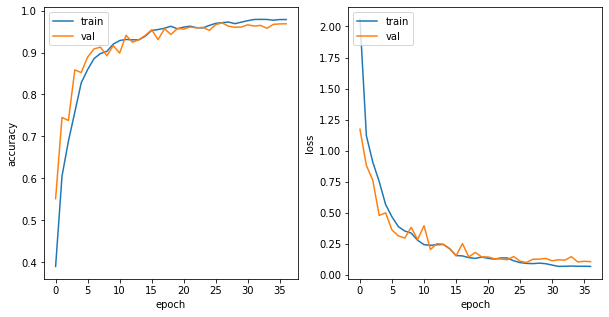

In [ ]:
plot_history(vgg19_history)

In [ ]:
vgg19_model.load_weights(model_path)

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg19_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 9882 images belonging to 10 classes.
Global F2 Score: 0.9678202792956891


Precision    Recall   F-Score  Support
AnnualCrop             0.936626  0.939719  0.938170   1211.0
Forest                 0.964630  0.996678  0.980392   1204.0
HerbaceousVegetation   0.970464  0.961538  0.965981   1196.0
Highway                0.989856  0.964580  0.977055   1214.0
Industrial             0.981157  0.972000  0.976557    750.0
Pasture                0.944179  0.986667  0.964955    600.0
PermanentCrop          0.941176  0.931116  0.936119    842.0
Residential            0.975418  0.998993  0.987065    993.0
River                  0.969873  0.975524  0.972690    858.0
SeaLake                0.998971  0.957594  0.977845   1014.0

In [ ]:
# confusion matrix as values
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                  1138       2  ...      9        1
Forest                         1    1200  ...      0        0
HerbaceousVegetation          12      16  ...      0        0
Highway                       23       0  ...      9        0
Industrial                     2       0  ...      0        0
Pasture                        2       4  ...      0        0
PermanentCrop                 18       1  ...      0        0
Residential                    0       0  ...      0        0
River                         10       1  ...    837        0
SeaLake                        9      20  ...      8      971

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 93.66    0.16  ...   1.04      0.1
Forest                      0.08   96.46  ...   0.00      0.0
HerbaceousVegetation        0.99    1.29  ...   0.00      0.0
Highway                     1.89    0.00  ...   1.04      0.0
Industrial                  0.16    0.00  ...   0.00      0.0
Pasture                     0.16    0.32  ...   0.00      0.0
PermanentCrop               1.48    0.08  ...   0.00      0.0
Residential                 0.00    0.00  ...   0.00      0.0
River                       0.82    0.08  ...  96.99      0.0
SeaLake                     0.74    1.61  ...   0.93     99.9

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
vgg19_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/vgg19_eurosat.h5')

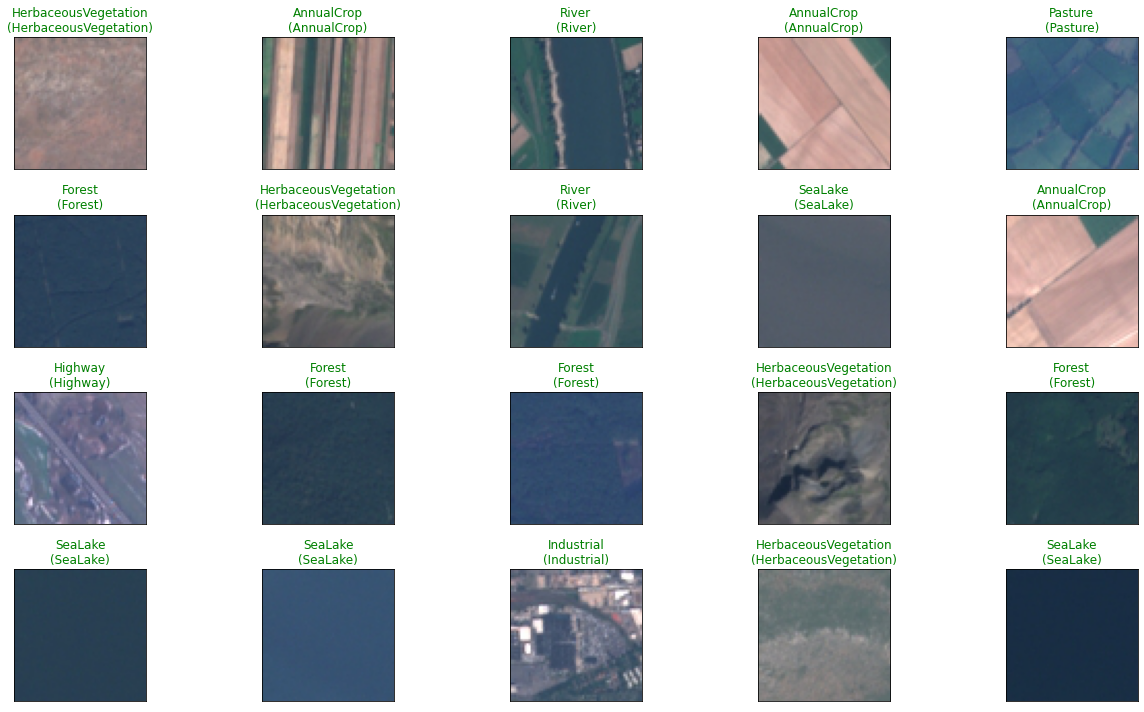

In [ ]:
plot_predictions(true_classes, predictions, test_generator_new, class_indices)

In [ ]:
# Re-train whole network end2end 
vgg19_model = compile_model('VGG19', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg19_model.load_weights(model_path)

train_generator.reset()
test_generator.reset()

vgg19_history = vgg19_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
147/147 [==============================] - 97s 649ms/step - loss: 0.2340 - categorical_accuracy: 0.9363 - val_loss: 0.2004 - val_categorical_accuracy: 0.9391

Epoch 00001: val_categorical_accuracy did not improve from 0.97088
Epoch 2/100
147/147 [==============================] - 96s 649ms/step - loss: 0.2051 - categorical_accuracy: 0.9425 - val_loss: 0.2395 - val_categorical_accuracy: 0.9302

Epoch 00002: val_categorical_accuracy did not improve from 0.97088
Epoch 3/100
147/147 [==============================] - 95s 642ms/step - loss: 0.1857 - categorical_accuracy: 0.9473 - val_loss: 0.3002 - val_categorical_accuracy: 0.9122

Epoch 00003: val_categorical_accuracy did not improve from 0.97088
Epoch 4/100
147/147 [==============================] - 94s 638ms/step - loss: 0.1795 - categorical_accuracy: 0.9493 - val_loss: 0.2646 - val_categorical_accuracy: 0.9199

Epoch 00004: val_categorical_accuracy did not improve from 0.97088
Epoch 5/100
147/147 [===========================

In [ ]:
vgg19_model.load_weights(model_path)

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg19_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 9882 images belonging to 10 classes.
Global F2 Score: 0.9722728192673546


Precision    Recall   F-Score  Support
AnnualCrop             0.939837  0.954583  0.947153   1211.0
Forest                 0.992550  0.995847  0.994196   1204.0
HerbaceousVegetation   0.970858  0.974916  0.972883   1196.0
Highway                0.986667  0.975288  0.980944   1214.0
Industrial             0.983762  0.969333  0.976494    750.0
Pasture                0.977778  0.953333  0.965401    600.0
PermanentCrop          0.942789  0.939430  0.941106    842.0
Residential            0.969667  0.997986  0.983623    993.0
River                  0.964079  0.969697  0.966880    858.0
SeaLake                0.994975  0.976331  0.985565   1014.0

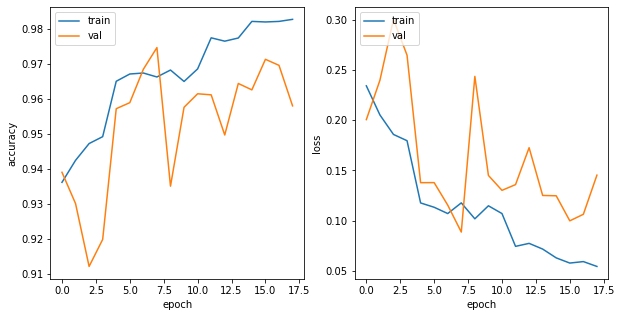

In [ ]:
plot_history(vgg19_history)

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 93.98    0.08  ...   0.93      0.4
Forest                      0.08   99.25  ...   0.12      0.1
HerbaceousVegetation        0.73    0.33  ...   0.00      0.0
Highway                     1.14    0.00  ...   0.58      0.0
Industrial                  0.41    0.00  ...   0.12      0.0
Pasture                     1.14    0.25  ...   0.00      0.0
PermanentCrop               1.14    0.00  ...   0.00      0.0
Residential                 0.00    0.00  ...   0.00      0.0
River                       0.98    0.00  ...  96.41      0.0
SeaLake                     0.41    0.08  ...   1.85     99.5

[10 rows x 10 columns]

In [ ]:
conf_mat

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                  1156       1  ...      8        4
Forest                         1    1199  ...      1        1
HerbaceousVegetation           9       4  ...      0        0
Highway                       14       0  ...      5        0
Industrial                     5       0  ...      1        0
Pasture                       14       3  ...      0        0
PermanentCrop                 14       0  ...      0        0
Residential                    0       0  ...      0        0
River                         12       0  ...    832        0
SeaLake                        5       1  ...     16      990

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
vgg19_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/vgg19_eurosat2.h5')

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception

In [ ]:
# Note that for different CNN models we are using different setup of dense layers
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    
    if (cnn_base == 'ResNet50') or (cnn_base == 'ResNet50V2') or (cnn_base == 'ResNet152V2'):
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet50V2':
            conv_base = ResNet50V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        else:
            conv_base = ResNet152V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
       
    
    elif (cnn_base == 'VGG16') or (cnn_base == 'VGG19'):
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = VGG19(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
    elif (cnn_base == 'Xception') or (cnn_base == 'InceptionV3'):
        if cnn_base == 'Xception':
            conv_base = Xception(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = InceptionV3(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model) 
    elif (cnn_base == 'NasNetLarge') or (cnn_base == 'NasNetMobile'):
        if cnn_base == 'NasNetLarge':
            conv_base = NASNetLarge(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = NASNetMobile(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)      

In [ ]:
Xception_model = compile_model('Xception', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
Xception_model.summary()

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
model_path = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path,
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
Xception_history = Xception_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

In [ ]:
# Re-train whole network end2end 
Xception_model = compile_model('Xception', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

Xception_model.load_weights(model_path)

train_generator.reset()
test_generator.reset()

Xception_history = Xception_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

In [ ]:
plot_history(Xception_history)

In [ ]:
Xception_model.load_weights(model_path)

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = Xception_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

In [ ]:
# Save the model and the weights
Xception_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/Xception_eurosat.h5')

# NasNet Models

# EfficientNet Models

# NasNetLarge

In [ ]:
NasNetLarge_model = compile_model('NASNetLarge', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
NasNetLarge_model.summary()

343621632/343610240 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 31, 31, 96)   2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 31, 31, 96)   384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 31, 31, 96)   0           stem_bn1[0][0]                   
___________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
model_path = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path,
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
NasNetLarge_history = NasNetLarge_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
147/147 [==============================] - 6145s 42s/step - loss: 1.7290 - categorical_accuracy: 0.4672 - val_loss: 1.2254 - val_categorical_accuracy: 0.5882

Epoch 00001: val_categorical_accuracy improved from -inf to 0.58817, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
147/147 [==============================] - 106s 721ms/step - loss: 1.4708 - categorical_accuracy: 0.5321 - val_loss: 1.1915 - val_categorical_accuracy: 0.6093

Epoch 00002: val_categorical_accuracy improved from 0.58817 to 0.60927, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
147/147 [==============================] - 107s 730ms/step - loss: 1.3996 - categorical_accuracy: 0.5457 - val_loss: 1.1491 - val_categorical_accuracy: 0.6249

Epoch 00003: val_categorical_accuracy improved from 0.60927 to 0.62490, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/50
147/147 [==============================] - 107s 730ms/step - loss: 1.3964 - categorical_accuracy: 0.5492 - val_loss: 1.1695 - val_categorical_accuracy: 0.6108

Epoch 00004: val_categorical_accuracy did not improve from 0.62490
Epoch 5/50
147/147 [==============================] - 106s 721ms/step - loss: 1.3812

In [ ]:
# Re-train whole network end2end 
NasNetLarge_model = compile_model('NASNetLarge', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

NasNetLarge_model.load_weights(model_path)

train_generator.reset()
test_generator.reset()

NasNetLarge_history = NasNetLarge_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
147/147 [==============================] - 289s 2s/step - loss: 2.2665 - categorical_accuracy: 0.2519 - val_loss: 675.6967 - val_categorical_accuracy: 0.0946

Epoch 00001: val_categorical_accuracy did not improve from 0.66376
Epoch 2/100
147/147 [==============================] - 241s 2s/step - loss: 1.8401 - categorical_accuracy: 0.3705 - val_loss: 3348.9954 - val_categorical_accuracy: 0.0794

Epoch 00002: val_categorical_accuracy did not improve from 0.66376
Epoch 3/100
147/147 [==============================] - 241s 2s/step - loss: 1.2831 - categorical_accuracy: 0.5551 - val_loss: 2166.2356 - val_categorical_accuracy: 0.0860

Epoch 00003: val_categorical_accuracy did not improve from 0.66376
Epoch 4/100
147/147 [==============================] - 241s 2s/step - loss: 0.8543 - categorical_accuracy: 0.7142 - val_loss: 1455.4291 - val_categorical_accuracy: 0.1063

Epoch 00004: val_categorical_accuracy did not improve from 0.66376
Epoch 5/100
147/147 [========================

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/100
147/147 [==============================] - 242s 2s/step - loss: 0.1437 - categorical_accuracy: 0.9597 - val_loss: 7.1453 - val_categorical_accuracy: 0.7102

Epoch 00020: val_categorical_accuracy improved from 0.68933 to 0.71023, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 21/100
147/147 [==============================] - 241s 2s/step - loss: 0.1292 - categorical_accuracy: 0.9634 - val_loss: 5.8160 - val_categorical_accuracy: 0.7081

Epoch 00021: val_categorical_accuracy did not improve from 0.71023
Epoch 22/100
147/147 [==============================] - 241s 2s/step - loss: 0.1249 - categorical_accuracy: 0.9639 - val_loss: 3.6130 - val_categorical_accuracy: 0.7513

Epoch 00022: val_categorical_accuracy improved from 0.71023 to 0.75132, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 23/100
147/147 [==============================] - 241s 2s/step - loss: 0.1092 - c

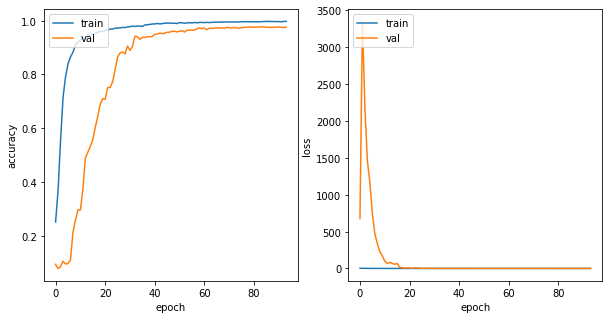

In [ ]:
plot_history(NasNetLarge_history)

In [ ]:
#test weights
#model_path1 = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.nasnet1.hdf5'

In [ ]:
# test weights
#model_path1 = '/content/drive/My Drive/model.weights.nasnet2.hdf5'

In [ ]:
NasNetLarge_model.load_weights(model_path)

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = NasNetLarge_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 9882 images belonging to 10 classes.
Global F2 Score: 0.9761181946974297


Precision    Recall   F-Score  Support
AnnualCrop             0.978495  0.976879  0.977686   1211.0
Forest                 0.978845  0.999169  0.988903   1204.0
HerbaceousVegetation   0.970174  0.979097  0.974615   1196.0
Highway                0.985774  0.970346  0.977999   1214.0
Industrial             0.976744  0.952000  0.964213    750.0
Pasture                0.994792  0.955000  0.974490    600.0
PermanentCrop          0.953682  0.953682  0.953682    842.0
Residential            0.950239  1.000000  0.974485    993.0
River                  0.976636  0.974359  0.975496    858.0
SeaLake                1.000000  0.978304  0.989033   1014.0

In [ ]:
prf

Precision    Recall   F-Score  Support
AnnualCrop             0.978495  0.976879  0.977686   1211.0
Forest                 0.978845  0.999169  0.988903   1204.0
HerbaceousVegetation   0.970174  0.979097  0.974615   1196.0
Highway                0.985774  0.970346  0.977999   1214.0
Industrial             0.976744  0.952000  0.964213    750.0
Pasture                0.994792  0.955000  0.974490    600.0
PermanentCrop          0.953682  0.953682  0.953682    842.0
Residential            0.950239  1.000000  0.974485    993.0
River                  0.976636  0.974359  0.975496    858.0
SeaLake                1.000000  0.978304  0.989033   1014.0

In [ ]:
conf_mat 

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                  1183       0  ...      5        0
Forest                         0    1203  ...      0        0
HerbaceousVegetation           2      11  ...      0        0
Highway                        2       0  ...      9        0
Industrial                     0       0  ...      0        0
Pasture                        7       5  ...      0        0
PermanentCrop                  6       1  ...      0        0
Residential                    0       0  ...      0        0
River                          4       0  ...    836        0
SeaLake                        5       9  ...      6      992

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 97.85    0.00  ...   0.58      0.0
Forest                      0.00   97.88  ...   0.00      0.0
HerbaceousVegetation        0.17    0.90  ...   0.00      0.0
Highway                     0.17    0.00  ...   1.05      0.0
Industrial                  0.00    0.00  ...   0.00      0.0
Pasture                     0.58    0.41  ...   0.00      0.0
PermanentCrop               0.50    0.08  ...   0.00      0.0
Residential                 0.00    0.00  ...   0.00      0.0
River                       0.33    0.00  ...  97.66      0.0
SeaLake                     0.41    0.73  ...   0.70    100.0

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
NasNetLarge_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/NasNetLarge_eurosat.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# NasNetMobile

In [ ]:
from tensorflow.keras.applications.nasnet import NASNetMobile

In [ ]:
NasNetMobile_model = compile_model('NASNetMobile', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
NasNetMobile_model.summary()

20004864/19993432 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 31, 31, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 31, 31, 32)   128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 31, 31, 32)   0           stem_bn1[0][0]                   
_____________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
model_path = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path,
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
NasNetMobile_history = NasNetMobile_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
147/147 [==============================] - 94s 513ms/step - loss: 1.7515 - categorical_accuracy: 0.5483 - val_loss: 1.1046 - val_categorical_accuracy: 0.6449

Epoch 00001: val_categorical_accuracy improved from -inf to 0.64489, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
147/147 [==============================] - 70s 477ms/step - loss: 1.1451 - categorical_accuracy: 0.6238 - val_loss: 0.9790 - val_categorical_accuracy: 0.6921

Epoch 00002: val_categorical_accuracy improved from 0.64489 to 0.69207, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
147/147 [==============================] - 69s 469ms/step - loss: 1.0582 - categorical_accuracy: 0.6498 - val_loss: 0.8982 - val_categorical_accuracy: 0.7100

Epoch 00003: val_categorical_accuracy improved from 0.69207 to 0.71002, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/50
147/147 [==============================] - 70s 474ms/step - loss: 1.0487 - categorical_accuracy: 0.6568 - val_loss: 0.8997 - val_categorical_accuracy: 0.7058

Epoch 00004: val_categorical_accuracy did not improve from 0.71002
Epoch 5/50
147/147 [==============================] - 69s 472ms/step - loss: 1.0390 - c

In [ ]:
# Re-train whole network end2end 
NasNetMobile_model = compile_model('NASNetMobile', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

NasNetMobile_model.load_weights(model_path)

train_generator.reset()
test_generator.reset()

NasNetMobile_history = NasNetMobile_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
147/147 [==============================] - 103s 517ms/step - loss: 2.1624 - categorical_accuracy: 0.4980 - val_loss: 3.2017 - val_categorical_accuracy: 0.5921

Epoch 00001: val_categorical_accuracy did not improve from 0.74239
Epoch 2/100
147/147 [==============================] - 72s 487ms/step - loss: 1.0587 - categorical_accuracy: 0.6693 - val_loss: 5.4427 - val_categorical_accuracy: 0.5457

Epoch 00002: val_categorical_accuracy did not improve from 0.74239
Epoch 3/100
147/147 [==============================] - 72s 488ms/step - loss: 0.7842 - categorical_accuracy: 0.7603 - val_loss: 8.3242 - val_categorical_accuracy: 0.5247

Epoch 00003: val_categorical_accuracy did not improve from 0.74239
Epoch 4/100
147/147 [==============================] - 72s 489ms/step - loss: 0.6342 - categorical_accuracy: 0.8056 - val_loss: 11.8302 - val_categorical_accuracy: 0.5120

Epoch 00004: val_categorical_accuracy did not improve from 0.74239
Epoch 5/100
147/147 [=========================

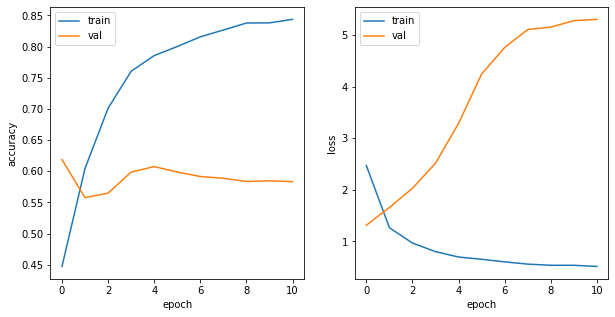

In [ ]:
plot_history(NasNetMobile_history)

In [ ]:
#test weights (debug)
# model_path1 = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.nasnet1.hdf5'

In [ ]:
# test weights (debug)
#model_path1 = '/content/drive/My Drive/model.weights.nasnet2.hdf5'

In [ ]:
NasNetMobile_model.load_weights(model_path)

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = NasNetMobile_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 9882 images belonging to 10 classes.
Global F2 Score: 0.6296296296296297


Precision    Recall   F-Score  Support
AnnualCrop             0.300105  0.939719  0.454927   1211.0
Forest                 0.845700  0.833056  0.839331   1204.0
HerbaceousVegetation   0.860158  0.545151  0.667349   1196.0
Highway                0.853035  0.439868  0.580435   1214.0
Industrial             0.864271  0.577333  0.692246    750.0
Pasture                0.848361  0.345000  0.490521    600.0
PermanentCrop          0.700647  0.514252  0.593151    842.0
Residential            0.729412  0.561934  0.634812    993.0
River                  0.838115  0.476690  0.607727    858.0
SeaLake                0.945796  0.843195  0.891554   1014.0

In [ ]:
conf_mat 

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                  1138       1  ...     11        3
Forest                       143    1003  ...      0       45
HerbaceousVegetation         401      70  ...      3        1
Highway                      504       0  ...     59        0
Industrial                   169       0  ...      1        0
Pasture                      294      35  ...      3        0
PermanentCrop                299       4  ...      0        0
Residential                  370      30  ...      1        0
River                        364       4  ...    409        0
SeaLake                      110      39  ...      1      855

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 30.01    0.08  ...   2.25     0.33
Forest                      3.77   84.57  ...   0.00     4.98
HerbaceousVegetation       10.57    5.90  ...   0.61     0.11
Highway                    13.29    0.00  ...  12.09     0.00
Industrial                  4.46    0.00  ...   0.20     0.00
Pasture                     7.75    2.95  ...   0.61     0.00
PermanentCrop               7.89    0.34  ...   0.00     0.00
Residential                 9.76    2.53  ...   0.20     0.00
River                       9.60    0.34  ...  83.81     0.00
SeaLake                     2.90    3.29  ...   0.20    94.58

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
NasNetMobile_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/NasNetMobile_eurosat.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# Save the model and the weights
NasNetMobile_model.save('/content/sample_data/models/EuroSAT/NasNetMobile_eurosat.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# EfficientNet B0 to B7

Evaluation of EfficientNet Models

# EfficientNetB0

In [ ]:
EfficientNetB0_model = compile_model('EfficientNetB0', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
EfficientNetB0_model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 64, 64, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 64, 64, 3)    7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 65, 65, 3)    0           normalization[0][0]              
___________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
model_path = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path,
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
EfficientNetB0_history = EfficientNetB0_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
147/147 [==============================] - 98s 616ms/step - loss: 4.1589 - categorical_accuracy: 0.1055 - val_loss: 2.2921 - val_categorical_accuracy: 0.1222

Epoch 00001: val_categorical_accuracy improved from -inf to 0.12216, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
147/147 [==============================] - 89s 604ms/step - loss: 2.2967 - categorical_accuracy: 0.1090 - val_loss: 2.2917 - val_categorical_accuracy: 0.1222

Epoch 00002: val_categorical_accuracy did not improve from 0.12216
Epoch 3/50
147/147 [==============================] - 89s 604ms/step - loss: 2.2963 - categorical_accuracy: 0.1050 - val_loss: 2.2902 - val_categorical_accuracy: 0.1229

Epoch 00003: val_categorical_accuracy improved from 0.12216 to 0.12287, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/50
147/147 [==============================] - 88s 597ms/step - loss: 2.2959 - categorical_accuracy: 0.1054 - val_loss: 2.2892 - val_categorical_accuracy: 0.1213

Epoch 00004: val_categorical_accuracy did not improve from 0.12287
Epoch 5/50
147/147 [==============================] - 88s 600ms/step - loss: 2.2961 - categorical_accuracy: 0.1099 - val_loss: 2.2925 - val_categorical_accuracy: 0.1002

Epoch 00005: val_c

In [ ]:
# Re-train whole network end2end 
EfficientNetB0_model = compile_model('EfficientNetB0', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

EfficientNetB0_model.load_weights(model_path)

train_generator.reset()
test_generator.reset()

EfficientNetB0_history = EfficientNetB0_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
147/147 [==============================] - 107s 653ms/step - loss: 398.3854 - categorical_accuracy: 0.2703 - val_loss: 2.3082 - val_categorical_accuracy: 0.1008

Epoch 00001: val_categorical_accuracy did not improve from 0.12287
Epoch 2/100
147/147 [==============================] - 93s 629ms/step - loss: 3.4108 - categorical_accuracy: 0.5481 - val_loss: 3.5817 - val_categorical_accuracy: 0.0900

Epoch 00002: val_categorical_accuracy did not improve from 0.12287
Epoch 3/100
147/147 [==============================] - 92s 625ms/step - loss: 1.5696 - categorical_accuracy: 0.6485 - val_loss: 3.4228 - val_categorical_accuracy: 0.0662

Epoch 00003: val_categorical_accuracy did not improve from 0.12287
Epoch 4/100
147/147 [==============================] - 94s 641ms/step - loss: 1.1644 - categorical_accuracy: 0.6776 - val_loss: 1412.5142 - val_categorical_accuracy: 0.3049

Epoch 00004: val_categorical_accuracy improved from 0.12287 to 0.30489, saving model to /content/drive/My Dri

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/100
147/147 [==============================] - 93s 632ms/step - loss: 1.1042 - categorical_accuracy: 0.6927 - val_loss: 1.9235 - val_categorical_accuracy: 0.4314

Epoch 00005: val_categorical_accuracy improved from 0.30489 to 0.43141, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 6/100
147/147 [==============================] - 92s 624ms/step - loss: 0.9201 - categorical_accuracy: 0.7002 - val_loss: 1.3461 - val_categorical_accuracy: 0.6624

Epoch 00006: val_categorical_accuracy improved from 0.43141 to 0.66244, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 7/100
147/147 [==============================] - 92s 623ms/step - loss: 0.8459 - categorical_accuracy: 0.7165 - val_loss: 1.8142 - val_categorical_accuracy: 0.7427

Epoch 00007: val_categorical_accuracy improved from 0.66244 to 0.74269, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.w

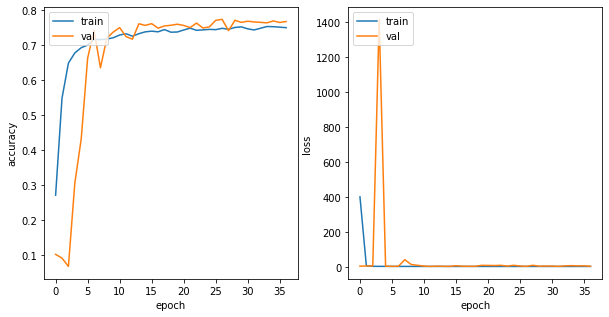

In [ ]:
plot_history(EfficientNetB0_history)

In [ ]:
#test weights (debug)
# model_path1 = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.nasnet1.hdf5'

In [ ]:
# test weights (debug)
#model_path1 = '/content/drive/My Drive/model.weights.nasnet2.hdf5'

In [ ]:
EfficientNetB0_model.load_weights(model_path)

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = EfficientNetB0_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 9882 images belonging to 10 classes.
Global F2 Score: 0.730722525804493


Precision    Recall   F-Score  Support
AnnualCrop             0.445267  0.893476  0.594342   1211.0
Forest                 0.884821  0.963455  0.922465   1204.0
HerbaceousVegetation   0.833843  0.683946  0.751493   1196.0
Highway                0.828846  0.355025  0.497116   1214.0
Industrial             0.796053  0.806667  0.801325    750.0
Pasture                0.783964  0.586667  0.671115    600.0
PermanentCrop          0.756757  0.465558  0.576471    842.0
Residential            0.750581  0.975831  0.848511    993.0
River                  0.715339  0.565268  0.631510    858.0
SeaLake                0.981992  0.914201  0.946885   1014.0

In [ ]:
conf_mat 

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                  1082       3  ...     28        9
Forest                        18    1160  ...      2        1
HerbaceousVegetation         162      32  ...      3        0
Highway                      429       0  ...    129        1
Industrial                    59       0  ...      3        0
Pasture                      129      67  ...     20        1
PermanentCrop                247       0  ...      4        0
Residential                   14       0  ...      0        0
River                        250      14  ...    485        5
SeaLake                       40      35  ...      4      927

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 44.53    0.23  ...   4.13     0.95
Forest                      0.74   88.48  ...   0.29     0.11
HerbaceousVegetation        6.67    2.44  ...   0.44     0.00
Highway                    17.65    0.00  ...  19.03     0.11
Industrial                  2.43    0.00  ...   0.44     0.00
Pasture                     5.31    5.11  ...   2.95     0.11
PermanentCrop              10.16    0.00  ...   0.59     0.00
Residential                 0.58    0.00  ...   0.00     0.00
River                      10.29    1.07  ...  71.53     0.53
SeaLake                     1.65    2.67  ...   0.59    98.20

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
EfficientNetB0_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/EfficientNetB0_eurosat.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# EfficientNet B1

In [ ]:
EfficientNetB1_model = compile_model('EfficientNetB1', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
EfficientNetB1_model.summary()

27033600/27018416 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 64, 64, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 64, 64, 3)    7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 65, 65, 3)    0           normalization[0][0]              
_____________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
model_path = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path,
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
EfficientNetB1_history = EfficientNetB1_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
147/147 [==============================] - 9817s 67s/step - loss: 3.7933 - categorical_accuracy: 0.1069 - val_loss: 2.2896 - val_categorical_accuracy: 0.1213

Epoch 00001: val_categorical_accuracy improved from -inf to 0.12135, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
147/147 [==============================] - 61s 414ms/step - loss: 2.3107 - categorical_accuracy: 0.1064 - val_loss: 2.2865 - val_categorical_accuracy: 0.1213

Epoch 00002: val_categorical_accuracy did not improve from 0.12135
Epoch 3/50
147/147 [==============================] - 60s 407ms/step - loss: 2.3038 - categorical_accuracy: 0.1112 - val_loss: 2.2916 - val_categorical_accuracy: 0.1002

Epoch 00003: val_categorical_accuracy did not improve from 0.12135
Epoch 4/50
147/147 [==============================] - 58s 395ms/step - loss: 2.2985 - categorical_accuracy: 0.1089 - val_loss: 2.2890 - val_categorical_accuracy: 0.1002

Epoch 00004: val_categorical_accuracy did not improve from 0.12135
Epoch 5/50
147/147 [==============================] - 58s 395ms/step - loss: 2.2956 - categorical_accuracy: 0.1115 - val_loss: 2.2913 - val_categorical_accuracy: 0.1229

Epoch 00005: val_categorical_accuracy improved from 0.12135 to 0.12287, saving model to /content/drive/My Drive/Colab N

In [ ]:
# Re-train whole network end2end 
EfficientNetB1_model = compile_model('EfficientNetB1', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

EfficientNetB1_model.load_weights(model_path)

train_generator.reset()
test_generator.reset()

EfficientNetB1_history = EfficientNetB1_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
147/147 [==============================] - 79s 452ms/step - loss: 474.9748 - categorical_accuracy: 0.2032 - val_loss: 2.3394 - val_categorical_accuracy: 0.1222

Epoch 00001: val_categorical_accuracy did not improve from 0.12216
Epoch 2/100
147/147 [==============================] - 64s 435ms/step - loss: 4.3850 - categorical_accuracy: 0.4247 - val_loss: 4.8407 - val_categorical_accuracy: 0.1004

Epoch 00002: val_categorical_accuracy did not improve from 0.12216
Epoch 3/100
147/147 [==============================] - 64s 438ms/step - loss: 1.6876 - categorical_accuracy: 0.5571 - val_loss: 18.0235 - val_categorical_accuracy: 0.0823

Epoch 00003: val_categorical_accuracy did not improve from 0.12216
Epoch 4/100
147/147 [==============================] - 64s 434ms/step - loss: 1.3879 - categorical_accuracy: 0.5868 - val_loss: 3.3629 - val_categorical_accuracy: 0.1031

Epoch 00004: val_categorical_accuracy did not improve from 0.12216
Epoch 5/100
147/147 [========================

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/100
147/147 [==============================] - 64s 435ms/step - loss: 1.1518 - categorical_accuracy: 0.6121 - val_loss: 1.8468 - val_categorical_accuracy: 0.3931

Epoch 00006: val_categorical_accuracy improved from 0.19957 to 0.39306, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 7/100
147/147 [==============================] - 64s 437ms/step - loss: 1.1970 - categorical_accuracy: 0.6144 - val_loss: 1.0249 - val_categorical_accuracy: 0.6478

Epoch 00007: val_categorical_accuracy improved from 0.39306 to 0.64783, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 8/100
147/147 [==============================] - 64s 436ms/step - loss: 1.1320 - categorical_accuracy: 0.6269 - val_loss: 0.9603 - val_categorical_accuracy: 0.6820

Epoch 00008: val_categorical_accuracy improved from 0.64783 to 0.68202, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.w

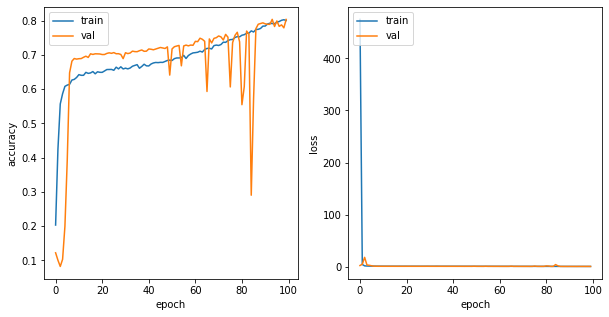

In [ ]:
plot_history(EfficientNetB1_history)

In [ ]:
#test weights (debug)
# model_path1 = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.nasnet1.hdf5'

In [ ]:
# test weights (debug)
#model_path1 = '/content/drive/My Drive/model.weights.nasnet2.hdf5'

In [ ]:
EfficientNetB1_model.load_weights(model_path)

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = EfficientNetB1_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 9882 images belonging to 10 classes.
Global F2 Score: 0.7781825541388383


Precision    Recall   F-Score  Support
AnnualCrop             0.549642  0.886870  0.678673   1211.0
Forest                 0.868950  0.969269  0.916372   1204.0
HerbaceousVegetation   0.822785  0.815217  0.818984   1196.0
Highway                0.856936  0.488468  0.622246   1214.0
Industrial             0.844595  0.833333  0.838926    750.0
Pasture                0.915014  0.538333  0.677859    600.0
PermanentCrop          0.755973  0.526128  0.620448    842.0
Residential            0.744361  0.996979  0.852346    993.0
River                  0.758847  0.674825  0.714374    858.0
SeaLake                0.983974  0.908284  0.944615   1014.0

In [ ]:
conf_mat 

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                  1074       6  ...     50        9
Forest                        12    1167  ...      1        2
HerbaceousVegetation          85      26  ...      1        1
Highway                      295       2  ...     98        1
Industrial                    27       0  ...      0        0
Pasture                      123      81  ...     23        0
PermanentCrop                176       0  ...      1        0
Residential                    0       0  ...      0        0
River                        133      15  ...    579        2
SeaLake                       29      46  ...     10      921

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 54.96    0.45  ...   6.55     0.96
Forest                      0.61   86.90  ...   0.13     0.21
HerbaceousVegetation        4.35    1.94  ...   0.13     0.11
Highway                    15.10    0.15  ...  12.84     0.11
Industrial                  1.38    0.00  ...   0.00     0.00
Pasture                     6.29    6.03  ...   3.01     0.00
PermanentCrop               9.01    0.00  ...   0.13     0.00
Residential                 0.00    0.00  ...   0.00     0.00
River                       6.81    1.12  ...  75.88     0.21
SeaLake                     1.48    3.43  ...   1.31    98.40

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
EfficientNetB1_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/EfficientNetB1_eurosat.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# EfficientNet B2

In [ ]:
EfficientNetB2_model = compile_model('EfficientNetB2', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
EfficientNetB2_model.summary()

31801344/31790344 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 64, 64, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 64, 64, 3)    7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 65, 65, 3)    0           normalization[0][0]              
___________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
model_path = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path,
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
EfficientNetB2_history = EfficientNetB2_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
147/147 [==============================] - 80s 478ms/step - loss: 4.4779 - categorical_accuracy: 0.1072 - val_loss: 2.2899 - val_categorical_accuracy: 0.1213

Epoch 00001: val_categorical_accuracy improved from -inf to 0.12135, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
147/147 [==============================] - 69s 467ms/step - loss: 2.2993 - categorical_accuracy: 0.1105 - val_loss: 2.2902 - val_categorical_accuracy: 0.1229

Epoch 00002: val_categorical_accuracy improved from 0.12135 to 0.12287, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
147/147 [==============================] - 68s 463ms/step - loss: 2.2966 - categorical_accuracy: 0.1097 - val_loss: 2.2913 - val_categorical_accuracy: 0.1213

Epoch 00003: val_categorical_accuracy did not improve from 0.12287
Epoch 4/50
147/147 [==============================] - 67s 455ms/step - loss: 2.2961 - categorical_accuracy: 0.1116 - val_loss: 2.2891 - val_categorical_accuracy: 0.1008

Epoch 00004: val_categorical_accuracy did not improve from 0.12287
Epoch 5/50
147/147 [==============================] - 68s 460ms/step - loss: 2.2982 - categorical_accuracy: 0.1085 - val_loss: 2.2923 - val_categorical_accuracy: 0.1002

Epoch 00005: val_c

In [ ]:
# Re-train whole network end2end 
EfficientNetB2_model = compile_model('EfficientNetB2', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

EfficientNetB2_model.load_weights(model_path)

train_generator.reset()
test_generator.reset()

EfficientNetB2_history = EfficientNetB2_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
147/147 [==============================] - 85s 490ms/step - loss: 107.9213 - categorical_accuracy: 0.3063 - val_loss: 2.3203 - val_categorical_accuracy: 0.1073

Epoch 00001: val_categorical_accuracy did not improve from 0.12287
Epoch 2/100
147/147 [==============================] - 69s 470ms/step - loss: 2.5290 - categorical_accuracy: 0.5228 - val_loss: 2.5647 - val_categorical_accuracy: 0.1034

Epoch 00002: val_categorical_accuracy did not improve from 0.12287
Epoch 3/100
147/147 [==============================] - 70s 473ms/step - loss: 1.4060 - categorical_accuracy: 0.6158 - val_loss: 3.6275 - val_categorical_accuracy: 0.1112

Epoch 00003: val_categorical_accuracy did not improve from 0.12287
Epoch 4/100
147/147 [==============================] - 70s 473ms/step - loss: 1.0997 - categorical_accuracy: 0.6472 - val_loss: 8.0987 - val_categorical_accuracy: 0.1186

Epoch 00004: val_categorical_accuracy did not improve from 0.12287
Epoch 5/100
147/147 [=========================

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/100
147/147 [==============================] - 70s 477ms/step - loss: 0.9652 - categorical_accuracy: 0.6769 - val_loss: 1.3087 - val_categorical_accuracy: 0.5344

Epoch 00006: val_categorical_accuracy improved from 0.19156 to 0.53440, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 7/100
147/147 [==============================] - 70s 478ms/step - loss: 0.9148 - categorical_accuracy: 0.6921 - val_loss: 1.0827 - val_categorical_accuracy: 0.6466

Epoch 00007: val_categorical_accuracy improved from 0.53440 to 0.64661, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 8/100
147/147 [==============================] - 69s 472ms/step - loss: 0.8979 - categorical_accuracy: 0.6935 - val_loss: 0.8498 - val_categorical_accuracy: 0.7015

Epoch 00008: val_categorical_accuracy improved from 0.64661 to 0.70150, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.w

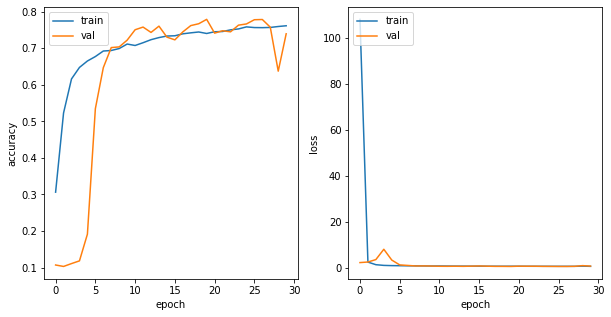

In [ ]:
plot_history(EfficientNetB2_history)

In [ ]:
#test weights (debug)
# model_path1 = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.nasnet1.hdf5'

In [ ]:
# test weights (debug)
#model_path1 = '/content/drive/My Drive/model.weights.nasnet2.hdf5'

In [ ]:
EfficientNetB2_model.load_weights(model_path)

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = EfficientNetB2_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 9882 images belonging to 10 classes.
Global F2 Score: 0.7349726775956285


Precision    Recall   F-Score  Support
AnnualCrop             0.446178  0.920727  0.601078   1211.0
Forest                 0.872260  0.958472  0.913336   1204.0
HerbaceousVegetation   0.861642  0.640468  0.734772   1196.0
Highway                0.840065  0.428336  0.567376   1214.0
Industrial             0.816845  0.814667  0.815754    750.0
Pasture                0.817797  0.643333  0.720149    600.0
PermanentCrop          0.730849  0.419240  0.532830    842.0
Residential            0.745399  0.978852  0.846321    993.0
River                  0.770932  0.568765  0.654594    858.0
SeaLake                0.984649  0.885602  0.932503   1014.0

In [ ]:
conf_mat 

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                  1115       2  ...     23        6
Forest                        23    1154  ...      0        3
HerbaceousVegetation         202      39  ...      2        0
Highway                      405       0  ...     96        0
Industrial                    46       0  ...      1        0
Pasture                      120      45  ...     13        1
PermanentCrop                309       2  ...      6        0
Residential                    8       0  ...      0        0
River                        239      13  ...    488        4
SeaLake                       32      68  ...      4      898

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 44.62    0.15  ...   3.63     0.66
Forest                      0.92   87.23  ...   0.00     0.33
HerbaceousVegetation        8.08    2.95  ...   0.32     0.00
Highway                    16.21    0.00  ...  15.17     0.00
Industrial                  1.84    0.00  ...   0.16     0.00
Pasture                     4.80    3.40  ...   2.05     0.11
PermanentCrop              12.36    0.15  ...   0.95     0.00
Residential                 0.32    0.00  ...   0.00     0.00
River                       9.56    0.98  ...  77.09     0.44
SeaLake                     1.28    5.14  ...   0.63    98.46

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
EfficientNetB2_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/EfficientNetB2_eurosat.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# Save the model and the weights
EfficientNetB2_model.save('/content/sample_data/models/EuroSAT/EfficientNetB2_eurosat.h5')

# EfficientNet B3

In [ ]:
EfficientNetB3_model = compile_model('EfficientNetB3', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
EfficientNetB3_model.summary()

43950080/43941136 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 64, 64, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 64, 64, 3)    7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 65, 65, 3)    0           normalization[0][0]              
_____________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
model_path = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path,
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
EfficientNetB3_history = EfficientNetB3_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
147/147 [==============================] - 6638s 45s/step - loss: 4.7479 - categorical_accuracy: 0.1097 - val_loss: 2.2894 - val_categorical_accuracy: 0.1008

Epoch 00001: val_categorical_accuracy improved from -inf to 0.10075, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
147/147 [==============================] - 88s 600ms/step - loss: 2.2989 - categorical_accuracy: 0.1101 - val_loss: 2.2913 - val_categorical_accuracy: 0.1213

Epoch 00002: val_categorical_accuracy improved from 0.10075 to 0.12135, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
147/147 [==============================] - 87s 589ms/step - loss: 2.2976 - categorical_accuracy: 0.1106 - val_loss: 2.2882 - val_categorical_accuracy: 0.1002

Epoch 00003: val_categorical_accuracy did not improve from 0.12135
Epoch 4/50
147/147 [==============================] - 86s 588ms/step - loss: 2.2978 - categorical_accuracy: 0.1091 - val_loss: 2.2925 - val_categorical_accuracy: 0.1222

Epoch 00004: val_categorical_accuracy improved from 0.12135 to 0.12216, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 5/50
147/147 [==============================] - 87s 592ms/step - loss: 2.2990 - c

In [ ]:
# Re-train whole network end2end 
EfficientNetB3_model = compile_model('EfficientNetB3', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

EfficientNetB3_model.load_weights(model_path)

train_generator.reset()
test_generator.reset()

EfficientNetB3_history = EfficientNetB3_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
147/147 [==============================] - 122s 700ms/step - loss: 333.4918 - categorical_accuracy: 0.2567 - val_loss: 2.6256 - val_categorical_accuracy: 0.1229

Epoch 00001: val_categorical_accuracy did not improve from 0.12287
Epoch 2/100
147/147 [==============================] - 99s 671ms/step - loss: 3.5481 - categorical_accuracy: 0.5137 - val_loss: 4.6216 - val_categorical_accuracy: 0.1229

Epoch 00002: val_categorical_accuracy did not improve from 0.12287
Epoch 3/100
147/147 [==============================] - 98s 666ms/step - loss: 5.9982 - categorical_accuracy: 0.5778 - val_loss: 3.5322 - val_categorical_accuracy: 0.1347

Epoch 00003: val_categorical_accuracy improved from 0.12287 to 0.13474, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/100
147/147 [==============================] - 99s 673ms/step - loss: 1.6533 - categorical_accuracy: 0.6090 - val_loss: 9.3506 - val_categorical_accuracy: 0.2499

Epoch 00004: val_categorical_accuracy improved from 0.13474 to 0.24990, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 5/100
147/147 [==============================] - 100s 677ms/step - loss: 1.1629 - categorical_accuracy: 0.6316 - val_loss: 2.6778 - val_categorical_accuracy: 0.3360

Epoch 00005: val_categorical_accuracy improved from 0.24990 to 0.33604, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 6/100
147/147 [==============================] - 100s 678ms/step - loss: 1.1735 - categorical_accuracy: 0.6430 - val_loss: 1.4344 - val_categorical_accuracy: 0.5082

Epoch 00006: val_categorical_accuracy improved from 0.33604 to 0.50822, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model

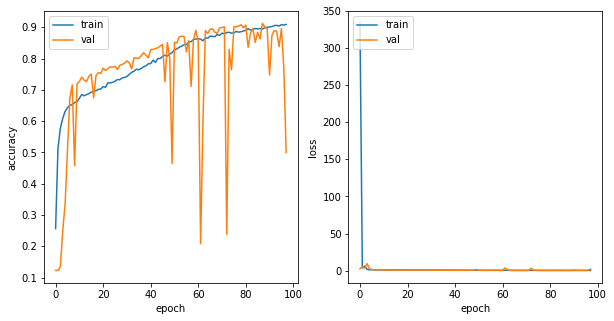

In [ ]:
plot_history(EfficientNetB3_history)

In [ ]:
#test weights (debug)
# model_path1 = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.nasnet1.hdf5'

In [ ]:
# test weights (debug)
#model_path1 = '/content/drive/My Drive/model.weights.nasnet2.hdf5'

In [ ]:
EfficientNetB3_model.load_weights(model_path)

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = EfficientNetB3_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 9882 images belonging to 10 classes.
Global F2 Score: 0.904675166970249


Precision    Recall   F-Score  Support
AnnualCrop             0.807832  0.919901  0.860232   1211.0
Forest                 0.969748  0.958472  0.964077   1204.0
HerbaceousVegetation   0.866409  0.938127  0.900843   1196.0
Highway                0.913809  0.812191  0.860009   1214.0
Industrial             0.943912  0.920000  0.931803    750.0
Pasture                0.951128  0.843333  0.893993    600.0
PermanentCrop          0.849435  0.804038  0.826113    842.0
Residential            0.908088  0.994965  0.949543    993.0
River                  0.905897  0.841492  0.872508    858.0
SeaLake                0.986922  0.967456  0.977092   1014.0

In [ ]:
conf_mat 

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                  1114       2  ...     14        9
Forest                        10    1154  ...      0        1
HerbaceousVegetation          25       3  ...      1        0
Highway                       76       0  ...     47        1
Industrial                    10       0  ...      1        0
Pasture                       25      22  ...      5        0
PermanentCrop                 56       0  ...      0        0
Residential                    1       0  ...      0        0
River                         50       0  ...    722        2
SeaLake                       12       9  ...      7      981

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

In [ ]:
# Save the model and the weights
EfficientNetB3_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/EfficientNetB3_eurosat.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# EfficientNet B4

In [ ]:
EfficientNetB4_model = compile_model('EfficientNetB4', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
EfficientNetB4_model.summary()

71696384/71686520 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 64, 64, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 64, 64, 3)    7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 65, 65, 3)    0           normalization[0][0]              
_____________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
model_path = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path,
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
EfficientNetB4_history = EfficientNetB4_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
147/147 [==============================] - 12002s 82s/step - loss: 5.3333 - categorical_accuracy: 0.1095 - val_loss: 2.2949 - val_categorical_accuracy: 0.1213

Epoch 00001: val_categorical_accuracy improved from -inf to 0.12135, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
147/147 [==============================] - 89s 603ms/step - loss: 2.2999 - categorical_accuracy: 0.1064 - val_loss: 2.2919 - val_categorical_accuracy: 0.1002

Epoch 00002: val_categorical_accuracy did not improve from 0.12135
Epoch 3/50
147/147 [==============================] - 88s 598ms/step - loss: 2.2973 - categorical_accuracy: 0.1081 - val_loss: 2.2905 - val_categorical_accuracy: 0.1008

Epoch 00003: val_categorical_accuracy did not improve from 0.12135
Epoch 4/50
147/147 [==============================] - 88s 599ms/step - loss: 2.2960 - categorical_accuracy: 0.1147 - val_loss: 2.2880 - val_categorical_accuracy: 0.1008

Epoch 00004: val_categorical_accuracy did not improve from 0.12135
Epoch 5/50
147/147 [==============================] - 88s 598ms/step - loss: 2.3089 - categorical_accuracy: 0.1116 - val_loss: 2.2984 - val_categorical_accuracy: 0.1229

Epoch 00005: val_categorical_accuracy improved from 0.12135 to 0.12287, saving model to /content/drive/My Drive/Colab N

In [ ]:
# Re-train whole network end2end 
EfficientNetB4_model = compile_model('EfficientNetB4', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

EfficientNetB4_model.load_weights(model_path)

train_generator.reset()
test_generator.reset()

EfficientNetB4_history = EfficientNetB4_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
147/147 [==============================] - 132s 739ms/step - loss: 132.1060 - categorical_accuracy: 0.2365 - val_loss: 2.4361 - val_categorical_accuracy: 0.0854

Epoch 00001: val_categorical_accuracy did not improve from 0.12287
Epoch 2/100
147/147 [==============================] - 104s 707ms/step - loss: 2.7600 - categorical_accuracy: 0.5044 - val_loss: 3.1557 - val_categorical_accuracy: 0.1153

Epoch 00002: val_categorical_accuracy did not improve from 0.12287
Epoch 3/100
147/147 [==============================] - 104s 704ms/step - loss: 1.5814 - categorical_accuracy: 0.5744 - val_loss: 2.9479 - val_categorical_accuracy: 0.1370

Epoch 00003: val_categorical_accuracy improved from 0.12287 to 0.13697, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/100
147/147 [==============================] - 104s 702ms/step - loss: 1.9197 - categorical_accuracy: 0.5992 - val_loss: 2.7510 - val_categorical_accuracy: 0.1808

Epoch 00004: val_categorical_accuracy improved from 0.13697 to 0.18080, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 5/100
147/147 [==============================] - 103s 701ms/step - loss: 1.2227 - categorical_accuracy: 0.6041 - val_loss: 1.9415 - val_categorical_accuracy: 0.3078

Epoch 00005: val_categorical_accuracy improved from 0.18080 to 0.30783, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 6/100
147/147 [==============================] - 104s 706ms/step - loss: 1.1354 - categorical_accuracy: 0.6176 - val_loss: 1.2365 - val_categorical_accuracy: 0.5691

Epoch 00006: val_categorical_accuracy improved from 0.30783 to 0.56909, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/mode

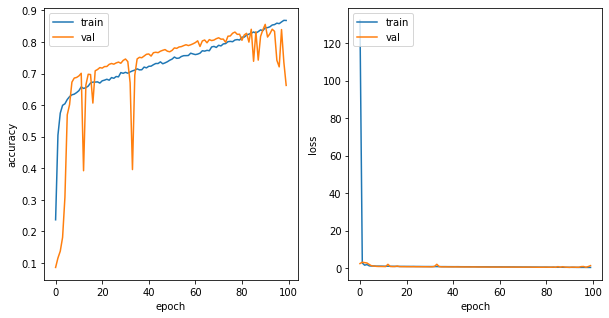

In [ ]:
plot_history(EfficientNetB4_history)

In [ ]:
#test weights (debug)
# model_path1 = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.nasnet1.hdf5'

In [ ]:
# test weights (debug)
#model_path1 = '/content/drive/My Drive/model.weights.nasnet2.hdf5'

In [ ]:
EfficientNetB4_model.load_weights(model_path)

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = EfficientNetB4_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 9882 images belonging to 10 classes.
Global F2 Score: 0.8345476624165149


Precision    Recall   F-Score  Support
AnnualCrop             0.627571  0.932287  0.750166   1211.0
Forest                 0.918046  0.967608  0.942175   1204.0
HerbaceousVegetation   0.910630  0.809365  0.857016   1196.0
Highway                0.911280  0.592257  0.717923   1214.0
Industrial             0.876694  0.862667  0.869624    750.0
Pasture                0.828990  0.848333  0.838550    600.0
PermanentCrop          0.771283  0.720903  0.745242    842.0
Residential            0.820470  0.984894  0.895195    993.0
River                  0.877698  0.710956  0.785576    858.0
SeaLake                0.977564  0.902367  0.938462   1014.0

In [ ]:
conf_mat 

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                  1129       3  ...     10       13
Forest                        13    1165  ...      0        1
HerbaceousVegetation          78       5  ...      4        1
Highway                      245       2  ...     66        0
Industrial                    22       0  ...      0        0
Pasture                       40      24  ...      1        0
PermanentCrop                112       0  ...      1        0
Residential                    4       1  ...      0        0
River                        123       9  ...    610        6
SeaLake                       33      60  ...      3      915

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 62.76    0.24  ...   1.44     1.39
Forest                      0.72   91.80  ...   0.00     0.11
HerbaceousVegetation        4.34    0.39  ...   0.58     0.11
Highway                    13.62    0.16  ...   9.50     0.00
Industrial                  1.22    0.00  ...   0.00     0.00
Pasture                     2.22    1.89  ...   0.14     0.00
PermanentCrop               6.23    0.00  ...   0.14     0.00
Residential                 0.22    0.08  ...   0.00     0.00
River                       6.84    0.71  ...  87.77     0.64
SeaLake                     1.83    4.73  ...   0.43    97.76

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
EfficientNetB4_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/EfficientNetB4_eurosat.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# EfficientNet B5

In [ ]:
EfficientNetB5_model = compile_model('EfficientNetB5', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
EfficientNetB5_model.summary()

115277824/115263384 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 64, 64, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 64, 64, 3)    7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 65, 65, 3)    0           normalization[0][0]              
___________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
model_path = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path,
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
EfficientNetB5_history = EfficientNetB5_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
147/147 [==============================] - 8960s 61s/step - loss: 5.2544 - categorical_accuracy: 0.1084 - val_loss: 2.2898 - val_categorical_accuracy: 0.1229

Epoch 00001: val_categorical_accuracy improved from -inf to 0.12287, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
147/147 [==============================] - 61s 411ms/step - loss: 2.3003 - categorical_accuracy: 0.1067 - val_loss: 2.2930 - val_categorical_accuracy: 0.1002

Epoch 00002: val_categorical_accuracy did not improve from 0.12287
Epoch 3/50
147/147 [==============================] - 60s 406ms/step - loss: 2.3047 - categorical_accuracy: 0.1108 - val_loss: 2.2902 - val_categorical_accuracy: 0.1229

Epoch 00003: val_categorical_accuracy did not improve from 0.12287
Epoch 4/50
147/147 [==============================] - 60s 408ms/step - loss: 2.2968 - categorical_accuracy: 0.1107 - val_loss: 2.2898 - val_categorical_accuracy: 0.1222

Epoch 00004: val_categorical_accuracy did not improve from 0.12287
Epoch 5/50
147/147 [==============================] - 60s 408ms/step - loss: 2.2964 - categorical_accuracy: 0.1092 - val_loss: 2.2923 - val_categorical_accuracy: 0.1222

Epoch 00005: val_categorical_accuracy did not improve from 0.12287
Epoch 6/50
147/147 [==============================] 

In [ ]:
# Re-train whole network end2end 
EfficientNetB5_model = compile_model('EfficientNetB5', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

EfficientNetB5_model.load_weights(model_path)

train_generator.reset()
test_generator.reset()

EfficientNetB5_history = EfficientNetB5_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
147/147 [==============================] - 101s 544ms/step - loss: 97.8726 - categorical_accuracy: 0.2455 - val_loss: 2.4578 - val_categorical_accuracy: 0.1254

Epoch 00001: val_categorical_accuracy improved from 0.12287 to 0.12541, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
147/147 [==============================] - 75s 510ms/step - loss: 4.2423 - categorical_accuracy: 0.4746 - val_loss: 3.1213 - val_categorical_accuracy: 0.1529

Epoch 00002: val_categorical_accuracy improved from 0.12541 to 0.15290, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/100
147/147 [==============================] - 76s 518ms/step - loss: 1.8528 - categorical_accuracy: 0.5567 - val_loss: 2.7133 - val_categorical_accuracy: 0.1868

Epoch 00003: val_categorical_accuracy improved from 0.15290 to 0.18679, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 4/100
147/147 [==============================] - 76s 518ms/step - loss: 1.5530 - categorical_accuracy: 0.5930 - val_loss: 2.6475 - val_categorical_accuracy: 0.2354

Epoch 00004: val_categorical_accuracy improved from 0.18679 to 0.23539, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.w

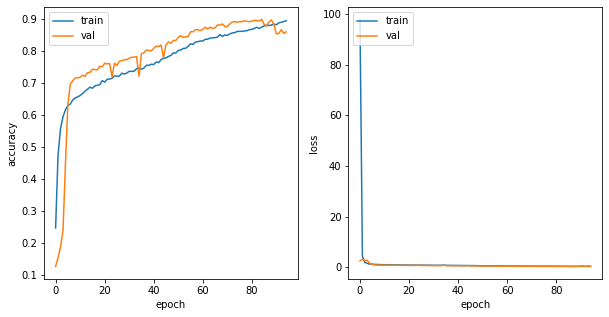

In [ ]:
plot_history(EfficientNetB5_history)

In [ ]:
#test weights (debug)
# model_path1 = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.nasnet1.hdf5'

In [ ]:
# test weights (debug)
#model_path1 = '/content/drive/My Drive/model.weights.nasnet2.hdf5'

In [ ]:
EfficientNetB5_model.load_weights(model_path)

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = EfficientNetB5_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 9882 images belonging to 10 classes.
Global F2 Score: 0.8877757538959725


Precision    Recall   F-Score  Support
AnnualCrop             0.767235  0.928159  0.840060   1211.0
Forest                 0.900383  0.975914  0.936628   1204.0
HerbaceousVegetation   0.904681  0.888796  0.896668   1196.0
Highway                0.936821  0.781713  0.852268   1214.0
Industrial             0.939219  0.865333  0.900763    750.0
Pasture                0.892336  0.815000  0.851916    600.0
PermanentCrop          0.815937  0.863420  0.839008    842.0
Residential            0.899267  0.988922  0.941966    993.0
River                  0.895674  0.820513  0.856448    858.0
SeaLake                0.994541  0.898422  0.944041   1014.0

In [ ]:
conf_mat 

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                  1124       3  ...     15        4
Forest                         9    1175  ...      1        0
HerbaceousVegetation          33      16  ...      4        0
Highway                      100       0  ...     52        0
Industrial                    20       0  ...      1        0
Pasture                       26      51  ...      3        0
PermanentCrop                 45       2  ...      0        0
Residential                    2       0  ...      0        0
River                         71       6  ...    704        1
SeaLake                       35      52  ...      6      911

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 76.72    0.23  ...   1.91     0.44
Forest                      0.61   90.04  ...   0.13     0.00
HerbaceousVegetation        2.25    1.23  ...   0.51     0.00
Highway                     6.83    0.00  ...   6.62     0.00
Industrial                  1.37    0.00  ...   0.13     0.00
Pasture                     1.77    3.91  ...   0.38     0.00
PermanentCrop               3.07    0.15  ...   0.00     0.00
Residential                 0.14    0.00  ...   0.00     0.00
River                       4.85    0.46  ...  89.57     0.11
SeaLake                     2.39    3.98  ...   0.76    99.45

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
EfficientNetB5_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/EfficientNetB5_eurosat.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# EfficientNet B6

In [ ]:
EfficientNetB6_model = compile_model('EfficientNetB6', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
EfficientNetB6_model.summary()

165249024/165234480 [==============================] - 1s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 64, 64, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 64, 64, 3)    7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 65, 65, 3)    0           normalization_2[0][0]            
_________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
model_path = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path,
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
EfficientNetB6_history = EfficientNetB6_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
147/147 [==============================] - 91s 500ms/step - loss: 4.7251 - categorical_accuracy: 0.1068 - val_loss: 2.2927 - val_categorical_accuracy: 0.1002

Epoch 00001: val_categorical_accuracy improved from -inf to 0.10024, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
147/147 [==============================] - 69s 471ms/step - loss: 2.2996 - categorical_accuracy: 0.1106 - val_loss: 2.2925 - val_categorical_accuracy: 0.1229

Epoch 00002: val_categorical_accuracy improved from 0.10024 to 0.12287, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
147/147 [==============================] - 69s 469ms/step - loss: 2.2996 - categorical_accuracy: 0.1106 - val_loss: 2.2904 - val_categorical_accuracy: 0.1213

Epoch 00003: val_categorical_accuracy did not improve from 0.12287
Epoch 4/50
147/147 [==============================] - 69s 466ms/step - loss: 2.3022 - categorical_accuracy: 0.1056 - val_loss: 2.2879 - val_categorical_accuracy: 0.1222

Epoch 00004: val_categorical_accuracy did not improve from 0.12287
Epoch 5/50
147/147 [==============================] - 69s 468ms/step - loss: 2.2972 - categorical_accuracy: 0.1082 - val_loss: 2.2925 - val_categorical_accuracy: 0.1002

Epoch 00005: val_c

In [ ]:
# Re-train whole network end2end 
EfficientNetB6_model = compile_model('EfficientNetB6', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

EfficientNetB6_model.load_weights(model_path)

train_generator.reset()
test_generator.reset()

EfficientNetB6_history = EfficientNetB6_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
147/147 [==============================] - 107s 541ms/step - loss: 120.2295 - categorical_accuracy: 0.2601 - val_loss: 2.3907 - val_categorical_accuracy: 0.1391

Epoch 00001: val_categorical_accuracy improved from 0.12287 to 0.13910, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
147/147 [==============================] - 76s 515ms/step - loss: 5.2836 - categorical_accuracy: 0.4626 - val_loss: 2.7364 - val_categorical_accuracy: 0.1228

Epoch 00002: val_categorical_accuracy did not improve from 0.13910
Epoch 3/100
147/147 [==============================] - 74s 503ms/step - loss: 1.8745 - categorical_accuracy: 0.5510 - val_loss: 3.2206 - val_categorical_accuracy: 0.1153

Epoch 00003: val_categorical_accuracy did not improve from 0.13910
Epoch 4/100
147/147 [==============================] - 74s 505ms/step - loss: 1.4093 - categorical_accuracy: 0.5943 - val_loss: 3.1489 - val_categorical_accuracy: 0.1323

Epoch 00004: val_categorical_accuracy did not improve from 0.13910
Epoch 5/100
147/147 [==============================] - 75s 506ms/step - loss: 1.2636 - categorical_accuracy: 0.6015 - val_loss: 1.9347 - val_categorical_accuracy: 0.3357

Epoch 00005: val_categorical_accuracy improved from 0.13910 to 0.33573, saving model to /content/drive/My Drive/Col

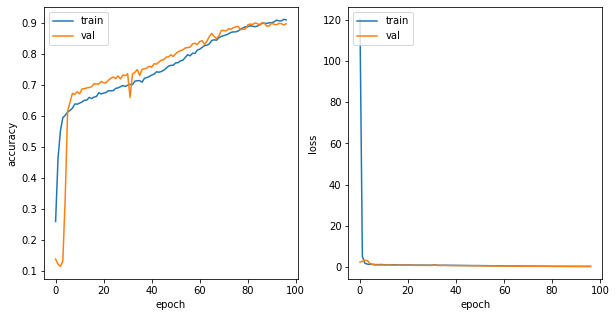

In [ ]:
plot_history(EfficientNetB6_history)

In [ ]:
#test weights (debug)
# model_path1 = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.nasnet1.hdf5'

In [ ]:
# test weights (debug)
#model_path1 = '/content/drive/My Drive/model.weights.nasnet2.hdf5'

In [ ]:
EfficientNetB6_model.load_weights(model_path)

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = EfficientNetB6_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 9882 images belonging to 10 classes.
Global F2 Score: 0.8930378465897592


Precision    Recall   F-Score  Support
AnnualCrop             0.803865  0.927333  0.861196   1211.0
Forest                 0.884471  0.979236  0.929444   1204.0
HerbaceousVegetation   0.875294  0.933110  0.903278   1196.0
Highway                0.911069  0.793245  0.848085   1214.0
Industrial             0.958631  0.896000  0.926258    750.0
Pasture                0.939583  0.751667  0.835185    600.0
PermanentCrop          0.837838  0.846793  0.842292    842.0
Residential            0.906593  0.996979  0.949640    993.0
River                  0.906716  0.849650  0.877256    858.0
SeaLake                0.996637  0.876726  0.932844   1014.0

In [ ]:
conf_mat 

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                  1123       3  ...      9        1
Forest                         3    1179  ...      0        0
HerbaceousVegetation          22      13  ...      1        0
Highway                       86       1  ...     54        0
Industrial                     8       0  ...      2        0
Pasture                       34      58  ...      5        0
PermanentCrop                 45       0  ...      0        0
Residential                    1       0  ...      0        0
River                         41       8  ...    729        2
SeaLake                       34      71  ...      4      889

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 80.39    0.23  ...   1.12     0.11
Forest                      0.21   88.45  ...   0.00     0.00
HerbaceousVegetation        1.57    0.98  ...   0.12     0.00
Highway                     6.16    0.08  ...   6.72     0.00
Industrial                  0.57    0.00  ...   0.25     0.00
Pasture                     2.43    4.35  ...   0.62     0.00
PermanentCrop               3.22    0.00  ...   0.00     0.00
Residential                 0.07    0.00  ...   0.00     0.00
River                       2.93    0.60  ...  90.67     0.22
SeaLake                     2.43    5.33  ...   0.50    99.66

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
EfficientNetB6_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/EfficientNetB6_eurosat.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# Save the model and the weights
EfficientNetB2_model.save('/content/sample_data/models/EuroSAT/EfficientNetB6_eurosat.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# EfficientNet B7

In [ ]:
#from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2
#from tensorflow.keras.applications import EfficientNetB3, EfficientNetB4, EfficientNetB5
#from tensorflow.keras.applications import EfficientNetB6, EfficientNetB7

In [ ]:
EfficientNetB7_model = compile_model('EfficientNetB7', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
EfficientNetB7_model.summary()

258088960/258076736 [==============================] - 3s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 64, 64, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 64, 64, 3)    7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 65, 65, 3)    0           normalization[0][0]              
_________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
model_path = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path,
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
EfficientNetB7_history = EfficientNetB7_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
147/147 [==============================] - 135s 757ms/step - loss: 5.6030 - categorical_accuracy: 0.1078 - val_loss: 2.2907 - val_categorical_accuracy: 0.1213

Epoch 00001: val_categorical_accuracy improved from -inf to 0.12135, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
147/147 [==============================] - 105s 713ms/step - loss: 2.3040 - categorical_accuracy: 0.1122 - val_loss: 2.2886 - val_categorical_accuracy: 0.1229

Epoch 00002: val_categorical_accuracy improved from 0.12135 to 0.12287, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 3/50
147/147 [==============================] - 104s 703ms/step - loss: 2.3039 - categorical_accuracy: 0.1115 - val_loss: 2.2892 - val_categorical_accuracy: 0.1229

Epoch 00003: val_categorical_accuracy did not improve from 0.12287
Epoch 4/50
147/147 [==============================] - 105s 712ms/step - loss: 2.3046 - categorical_accuracy: 0.1095 - val_loss: 2.2880 - val_categorical_accuracy: 0.1222

Epoch 00004: val_categorical_accuracy did not improve from 0.12287
Epoch 5/50
147/147 [==============================] - 104s 705ms/step - loss: 2.3010 - categorical_accuracy: 0.1072 - val_loss: 2.2880 - val_categorical_accuracy: 0.1229

Epoch 00005: v

In [ ]:
# Re-train whole network end2end 
EfficientNetB7_model = compile_model('EfficientNetB7', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

EfficientNetB7_model.load_weights(model_path)

train_generator.reset()
test_generator.reset()

EfficientNetB7_history = EfficientNetB7_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
147/147 [==============================] - 255s 1s/step - loss: 0.9816 - categorical_accuracy: 0.7474 - val_loss: 2.6633 - val_categorical_accuracy: 0.3136

Epoch 00001: val_categorical_accuracy did not improve from 0.74939
Epoch 2/100
147/147 [==============================] - 214s 1s/step - loss: 1.3146 - categorical_accuracy: 0.7525 - val_loss: 2.3104 - val_categorical_accuracy: 0.3750

Epoch 00002: val_categorical_accuracy did not improve from 0.74939
Epoch 3/100
147/147 [==============================] - 214s 1s/step - loss: 0.6547 - categorical_accuracy: 0.7740 - val_loss: 0.5810 - val_categorical_accuracy: 0.8018

Epoch 00003: val_categorical_accuracy improved from 0.74939 to 0.80185, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/100
147/147 [==============================] - 214s 1s/step - loss: 0.6130 - categorical_accuracy: 0.7884 - val_loss: 0.4646 - val_categorical_accuracy: 0.8374

Epoch 00004: val_categorical_accuracy improved from 0.80185 to 0.83736, saving model to /content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.best.hdf5
Epoch 5/100
147/147 [==============================] - 214s 1s/step - loss: 0.7712 - categorical_accuracy: 0.7819 - val_loss: 1.8500 - val_categorical_accuracy: 0.4553

Epoch 00005: val_categorical_accuracy did not improve from 0.83736
Epoch 6/100
147/147 [==============================] - 214s 1s/step - loss: 0.5916 - categorical_accuracy: 0.7960 - val_loss: 0.5684 - val_categorical_accuracy: 0.8026

Epoch 00006: val_categorical_accuracy did not improve from 0.83736
Epoch 7/100
147/147 [==============================] - 213s 1s/step - loss: 0.5680 - categorical_accuracy: 0.8074 - val_loss: 0.4342 - val_categorical_accuracy: 0.8495

Epoch 00007: val_categ

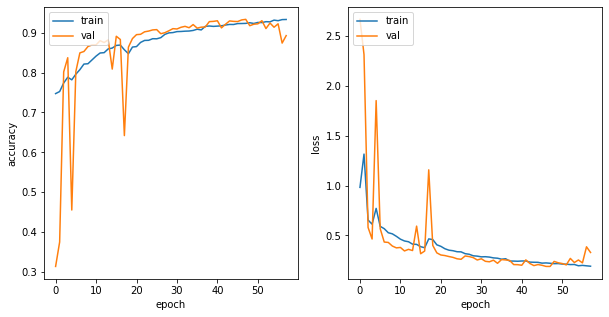

In [ ]:
plot_history(EfficientNetB7_history)

In [ ]:
#test weights (debug)
#model_path1 = '/content/drive/My Drive/Colab Notebooks/EuroSAT/working/model.weights.nasnet1.hdf5'

In [ ]:
# test weights (debug)
#model_path1 = '/content/drive/My Drive/model.weights.nasnet2.hdf5'

In [ ]:
EfficientNetB7_model.load_weights(model_path)

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = EfficientNetB7_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 9882 images belonging to 10 classes.
Global F2 Score: 0.9301760777170613


Precision    Recall   F-Score  Support
AnnualCrop             0.889503  0.930636  0.909605   1211.0
Forest                 0.920463  0.990033  0.953982   1204.0
HerbaceousVegetation   0.944254  0.920569  0.932261   1196.0
Highway                0.942659  0.893740  0.917548   1214.0
Industrial             0.948787  0.938667  0.943700    750.0
Pasture                0.948763  0.895000  0.921098    600.0
PermanentCrop          0.897094  0.880048  0.888489    842.0
Residential            0.912200  0.993958  0.951325    993.0
River                  0.927467  0.909091  0.918187    858.0
SeaLake                0.991543  0.925049  0.957143   1014.0

In [ ]:
conf_mat 

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                  1127       3  ...      9        5
Forest                         2    1192  ...      0        1
HerbaceousVegetation          21      16  ...      1        0
Highway                       32       1  ...     42        0
Industrial                     6       0  ...      1        0
Pasture                       12      26  ...      3        0
PermanentCrop                 34       1  ...      0        0
Residential                    1       1  ...      0        0
River                         19       1  ...    780        2
SeaLake                       13      54  ...      5      938

[10 rows x 10 columns]

In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

AnnualCrop  Forest  ...  River  SeaLake
AnnualCrop                 88.95    0.23  ...   1.07     0.53
Forest                      0.16   92.05  ...   0.00     0.11
HerbaceousVegetation        1.66    1.24  ...   0.12     0.00
Highway                     2.53    0.08  ...   4.99     0.00
Industrial                  0.47    0.00  ...   0.12     0.00
Pasture                     0.95    2.01  ...   0.36     0.00
PermanentCrop               2.68    0.08  ...   0.00     0.00
Residential                 0.08    0.08  ...   0.00     0.00
River                       1.50    0.08  ...  92.75     0.21
SeaLake                     1.03    4.17  ...   0.59    99.15

[10 rows x 10 columns]

In [ ]:
# Save the model and the weights
EfficientNetB7_model.save('/content/drive/My Drive/Colab Notebooks/EuroSAT/working/EfficientNetB7_eurosat.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
